# 1. 환경 설정 및 파일 준비

In [1]:
# Warnings 제거
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 패키지 및 라이브러리 설치
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import re
import itertools

import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
import plotly.express as px

from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import spearmanr, mannwhitneyu, shapiro, levene, norm, kruskal, chi2_contingency

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_auc_score

%config InlineBackend.figure_format = 'retina'

In [ ]:
# 파일 불러오기
log22_dpath = '/Users/aas/Desktop/코드잇/프로젝트/중급프로젝트/전체 자료 raw data/주제 1. 국내 채용시장 및 채용 플랫폼 이용패턴 분석/log_2022.csv'
log23_dpath = '/Users/aas/Desktop/코드잇/프로젝트/중급프로젝트/전체 자료 raw data/주제 1. 국내 채용시장 및 채용 플랫폼 이용패턴 분석/log_2023.csv'

log22 = pd.read_csv(log22_dpath, index_col=0)
log23 = pd.read_csv(log23_dpath, index_col=0)

# 2. 전처리

In [4]:
# 단일 파일로 병합
log = pd.concat([log22, log23])

In [5]:
# 결측값 삭제
num_missing = log.isna().any(axis=1).sum()
pct_missing = num_missing / len(log) * 100

print(f"전체 로그 수: {len(log)}")
print(f"결측값 수: {num_missing}({pct_missing:.2f}%)")

log.dropna(inplace=True)

print(f"처리 후 전체 로그 수: {len(log)}")
print(f"처리 후 결측값 수: {log.isna().any(axis=1).sum()}")

전체 로그 수: 17241907
결측값 수: 644156(3.74%)
처리 후 전체 로그 수: 16597751
처리 후 결측값 수: 0


In [6]:
# 중복값 삭제
print(f"전체 로그 수: {len(log)}")
print(f"중복값 수: {log.duplicated().sum()}({log.duplicated().sum() / len(log) * 100:.2f}%)")

log.drop_duplicates(inplace=True)

print(f"처리 후 전체 로그 수: {len(log)}")
print(f"처리 후 중복값 수: {log.duplicated().sum()}")

전체 로그 수: 16597751
중복값 수: 2921(0.02%)
처리 후 전체 로그 수: 16594830
처리 후 중복값 수: 0


In [7]:
# 더미 데이터 제거
dummy_mask = (log['URL'].str.startswith('api/timeline', na=False) 
            | log['URL'].str.contains('timeline\\?offset='))

print(f"전체 로그 수: {len(log)}")
print(f"더미데이터 수: {len(log[dummy_mask])}({len(log[dummy_mask]) / len(log) * 100:.2f}%)")

log = log[~dummy_mask]

print(f"처리 후 전체 로그 수: {len(log)}")
print(f"처리 후 더미데이터 수: {len(log[(log['URL'].str.startswith('api/timeline', na=False) | log['URL'].str.contains('timeline\\?offset='))])}")

전체 로그 수: 16594830
더미데이터 수: 167368(1.01%)
처리 후 전체 로그 수: 16427462
처리 후 더미데이터 수: 0


In [8]:
# 에러 기록 제거
error_mask = ~log['response_code'].isin([200, 301, 302])

print(f"response code 고유값: {log['response_code'].unique()}")
print(f"전체 로그 수: {len(log)}")
print(f"에러 기록 수: {len(log[error_mask])}({len(log[error_mask]) / len(log) * 100:.2f}%)")

log = log[~error_mask]

print(f"처리 후 전체 로그 수: {len(log)}")
print(f"처리 후 에러 기록 수: {len(log[~log['response_code'].isin([200, 301, 302])])}")

response code 고유값: [200 400 302 404 500 409 401 405 503 403 301]
전체 로그 수: 16427462
에러 기록 수: 127349(0.78%)
처리 후 전체 로그 수: 16300113
처리 후 에러 기록 수: 0


In [9]:
# 기업 로그 제거
company_pattern = [
    'api/companies/id/form',            # 기업 정보 등록/수정
    'api/jobs/form_data/media',         # 채용 공고 작성/수정
    'api/jobs/id/media/add',
    'jobs/id/edit',
    'api/jobs/widget/widget_templates'  # 채용 공고 위젯 템플릿
    'pricing/advertising',              # 기업 전용 요금
    'pricing/recruiting',
    'api/companies/id/ad_stat/'         # 광고 통계
]

regex_pattern = '|'.join(re.escape(p) for p in company_pattern)

company_mask = log['URL'].str.contains(regex_pattern, regex=True)

company_users = log[company_mask]['user_uuid'].unique()

print(f"전체 유저 수: {log['user_uuid'].nunique()}")
print(f"전체 로그 수: {len(log)}")
print("============================")
print(f"기업 유저 수: {len(company_users)}({len(company_users) / log['user_uuid'].nunique():.2f}%)")
print(f"기업 유저 로그 수: {len(log[log['user_uuid'].isin(company_users)])}({len(log[log['user_uuid'].isin(company_users)]) / len(log) * 100:.2f}%)")

log = log[~log['user_uuid'].isin(company_users)]

print("============================")
company_mask = log['URL'].str.contains(regex_pattern, regex=True)
print('처리 후 전체 유저 수: ', len(log['user_uuid'].unique()))
print(f"처리 후 전체 로그 수: {len(log)}")
print(f"처리 후 기업 유저 로그 수: {len(log[company_mask])}")

전체 유저 수: 21327
전체 로그 수: 16300113
기업 유저 수: 1657(0.08%)
기업 유저 로그 수: 3524549(21.62%)
처리 후 전체 유저 수:  19670
처리 후 전체 로그 수: 12775564
처리 후 기업 유저 로그 수: 0


In [10]:
# 관리자 로그 제거
admin_pattern = r"^admin$|^admin/core/profile"

admin_mask = log['URL'].str.contains(admin_pattern, regex=True)

admin_users = log[admin_mask]['user_uuid'].unique()

print(f"전체 유저 수: {log['user_uuid'].nunique()}")
print(f"전체 로그 수: {len(log)}")
print("============================")
print(f"관리자 유저 수: {len(admin_users)}({len(admin_users) / log['user_uuid'].nunique():.2f}%)")
print(f"관리자 유저 로그 수: {len(log[admin_mask])}({len(log[admin_mask]) / len(log) * 100:.2f}%)")

log = log[~log['user_uuid'].isin(admin_users)]

print("============================")
admin_mask = log['URL'].str.contains(regex_pattern, regex=True)
print('처리 후 전체 유저 수: ', len(log['user_uuid'].unique()))
print(f"처리 후 전체 로그 수: {len(log)}")
print(f"처리 후 관리자 유저 로그 수: {len(log[admin_mask])}")

전체 유저 수: 19670
전체 로그 수: 12775564
관리자 유저 수: 2(0.00%)
관리자 유저 로그 수: 312(0.00%)
처리 후 전체 유저 수:  19668
처리 후 전체 로그 수: 12771765
처리 후 관리자 유저 로그 수: 0


In [11]:
#시계열 데이터 변환

# timestamp
log['timestamp_clean'] = log['timestamp'].str.replace(' UTC', '', regex=False)
has_dot = log['timestamp_clean'].str.contains('\.')
log.loc[has_dot, 'timestamp_parsed'] = pd.to_datetime(log.loc[has_dot, 'timestamp_clean'], format="%Y-%m-%d %H:%M:%S.%f")
log.loc[~has_dot, 'timestamp_parsed'] = pd.to_datetime(log.loc[~has_dot, 'timestamp_clean'], format="%Y-%m-%d %H:%M:%S")
log = log.drop(columns=['timestamp', 'timestamp_clean'])

# date, year, month
log['date'] = pd.to_datetime(log['date'])
log['year'] = log['date'].dt.year
log['month'] = log['date'].dt.month

# # signup_time
# log['signup_time'] = pd.to_datetime(log['signup_time'])

In [12]:
# 세션 추가
# 이전 시간과의 차이 계산
log['prev_timestamp'] = log.groupby('user_uuid')['timestamp_parsed'].shift(1)
log['time_diff'] = (log['timestamp_parsed'] - log['prev_timestamp']).dt.total_seconds()

# 30분(1800초) 이상이면 새로운 세션으로 판단
log['new_session'] = (log['time_diff'] > 1800) | (log['time_diff'].isna())

# 세션 ID 부여 (유저별 누적합)
log['session_id'] = log.groupby('user_uuid')['new_session'].cumsum()
log.drop(columns=['prev_timestamp', 'time_diff'], inplace=True)

In [13]:
# url 태깅
# 1. 행동 종류(action_type), 대상 종류(target_type) 태깅
# 행동 종류에 따른 조건 정의

# signup 조건
## 'signup' 포함 시: 행동분류 signup, 대상분류 none
signup_condition = log['URL'].str.contains('signup', na=False)


# search 마스크
search_pattern_job = (
    r'(search/job|jobs.*(job|specialty|career_type|salary|location|remote|language|stock|hiring_types|tag)|jobs\?keywords|companies/company_id/jobs)'
)
search_pattern_company = (
    r'(search/company|companies.*(tag|funding_volume|investment_volume|size|location|military_service)|companies\?keywords)'
)
search_pattern_people = (
    r'(search/people|people.*(status|job|specialty|company|school|location))'
)
search_pattern_general = r'search\?keywords|suggest\?q'

# search 조건
search_job_condition = log['URL'].str.contains(search_pattern_job, na=False, regex=True)

search_company_condition = log['URL'].str.contains(search_pattern_company, na=False, regex=True)

search_people_condition = log['URL'].str.contains(search_pattern_people, na=False, regex=True)

# general search: search 포함 + job/company/people 미포함 조건 추가
search_general_condition = (
    log['URL'].str.contains('search', na=False)
    & ~log['URL'].str.contains('job|company|people', na=False)
) | (log['URL'].str.contains(search_pattern_general, na=False, regex=True))

# search 미포함 조건(인적사항 기입 과정 중의 검색): api/search로 시작, name=포함
profile_condition = (
    log['URL'].str.startswith('api/search')
    & log['URL'].str.contains('name=')
)

# view 조건
## 'jobs/id/id_title'와 동일하면 행동분류 view, 대상분류 job
view_job_condition = log['URL']=='jobs/id/id_title'
## 'companies/company_id'와 동일하면 행동분류 view, 대상분류 company
view_company_condition = log['URL']=='companies/company_id'

# apply 조건
## jobs/id/apply또는 api/jobs/id/apply로 시작하면 행동분류 apply, 대상분류 job
apply_condition = (log['URL'].str.startswith('api/jobs/id/apply')) | (log['URL'].str.startswith('jobs/id/apply'))

# bookmark 조건
## (log['URL']=='api/jobs/id/bookmark') & (log['method']=='PUT') 해당하면 행동분류 bookmark, 대상분류 job
bookmark_condition = (log['URL'] == 'api/jobs/123/bookmark') & (log['method'] == 'PUT')

In [14]:
# 행동 종류, 대상 종류
# 행동 분류 초기화
log['action_type'] = 'none'
log['target_type'] = 'none'

# 조건에 따라 분류
# signup
log.loc[signup_condition, ['action_type', 'target_type']] = ['signup', 'none']

# search
log.loc[search_job_condition & ~profile_condition, ['action_type', 'target_type']] = ['search', 'job']
log.loc[search_company_condition & ~profile_condition, ['action_type', 'target_type']] = ['search', 'company']
log.loc[search_people_condition & ~profile_condition, ['action_type', 'target_type']] = ['search', 'people']
log.loc[search_general_condition & ~profile_condition, ['action_type', 'target_type']] = ['search', 'general']

# view
log.loc[view_job_condition, ['action_type', 'target_type']] = ['view', 'job']
log.loc[view_company_condition, ['action_type', 'target_type']] = ['view', 'company']

# apply
log.loc[apply_condition, ['action_type', 'target_type']] = ['apply', 'job']

# 지원 완료
log.loc[log['URL']=='api/jobs/id/apply/step4', ['action_type', 'target_type']] = ['app_submitted', 'job']

# bookmark
log.loc[bookmark_condition, ['action_type', 'target_type']] = ['bookmark', 'job']

In [15]:
# 주요 행동 여부
# 키워드 검색
log['searched_keyword'] = (~log['URL'].str.contains('api')) & (log['URL'].str.contains('keyword'))
# 채용 공고 확인
log['viewed_job'] = log['URL'] == 'jobs/id/id_title'
# 북마크 저장
log['bookmarked'] = log['URL'].str.fullmatch(r'api/jobs/.+/bookmark') & (log['method'].str.upper() == 'PUT')
# 지원 완료
log['applied'] = log['URL']=='api/jobs/id/apply/step4'

In [16]:
# 가입일
# signup 시점 추출
log = log.sort_values(by='timestamp_parsed')
signup_condition = log['URL'].str.contains('signup', na=False)
signup_time = log[signup_condition].groupby(by='user_uuid', as_index=False).first()
signup_time = signup_time[['user_uuid', 'timestamp_parsed']]
signup_time.columns = ['user_uuid', 'signup_time']

# 전체 데이터에 병합
log = log.merge(signup_time, on='user_uuid', how='left')

In [17]:
# 기존 유저(signup 기록 없는 유저) 기록 제거
mask_new_user = log['URL'].str.contains('signup')
all_users = set(log['user_uuid'].unique())
new_users = set(log[mask_new_user]['user_uuid'].unique())
existing_users = all_users - new_users

# 제거 기록
print('전체 유저 수', len(all_users))
print('전체 로그 수: ', len(log))
print('============================')
print(f'기존 유저 수: {len(existing_users)}({(len(existing_users)) / len(all_users) * 100:.2f}%)')
print(f'기존 유저 로그 수: {len(log[log['user_uuid'].isin(existing_users)])} ({len(log[log['user_uuid'].isin(existing_users)]) / len(log) * 100:.2f}%)')
log = log[log['user_uuid'].isin(new_users)]
print('============================')
print('처리 후 전체 유저 수: ', len(log['user_uuid'].unique()))
print('처리 후 전체 로그 수: ', len(log))
print(f'처리 후 기존 유저 로그 수: {len(log[log['user_uuid'].isin(existing_users)])}')

전체 유저 수 19668
전체 로그 수:  12771765
기존 유저 수: 12837(65.27%)
기존 유저 로그 수: 5892562 (46.14%)
처리 후 전체 유저 수:  6831
처리 후 전체 로그 수:  6879203
처리 후 기존 유저 로그 수: 0


In [18]:
# signup 이전 기록 있는 유저 기록 제거
is_before_signup = log['timestamp_parsed'] < log['signup_time']
invalid_users = log[is_before_signup]['user_uuid'].unique()

# 제거 기록
print('전체 유저 수', len(log['user_uuid'].unique()))
print('전체 로그 수: ', len(log))
print('============================')
print(f'signup 이전 기록 있는 유저 수: {len(invalid_users)}({(len(invalid_users)) / len(log['user_uuid'].unique()) * 100:.2f}%)')
print(f'signup 이전 기록 있는 유저 로그 수: {len(log[log['user_uuid'].isin(invalid_users)])} ({len(log[log['user_uuid'].isin(invalid_users)]) / len(log) * 100:.2f}%)')
log = log[~log['user_uuid'].isin(invalid_users)]
print('============================')
print('처리 후 전체 유저 수: ', len(log['user_uuid'].unique()))
print('처리 후 전체 로그 수: ', len(log))
print(f'처리 후 signup 이전 기록 있는 유저 로그 수: {len(log[log['user_uuid'].isin(invalid_users)])}')

전체 유저 수 6831
전체 로그 수:  6879203
signup 이전 기록 있는 유저 수: 1641(24.02%)
signup 이전 기록 있는 유저 로그 수: 1842780 (26.79%)
처리 후 전체 유저 수:  5190
처리 후 전체 로그 수:  5036423
처리 후 signup 이전 기록 있는 유저 로그 수: 0


In [19]:
print(f"전체 로그 수: {len(log)}")

전체 로그 수: 5036423


In [20]:
# timestamp 순 정렬
log.sort_values('timestamp_parsed', inplace=True)

# 3. AARRR 기반 EDA

```
[AARRR 결과 요약]
- 신규 가입자는 지속적으로 감소하는 추세이며, 이는 전환 유도를 통한 효율적인 유저 확보가 중요한 상황임을 시사한다.
- 가입 후 1개월은 유저의 67.84%가 첫 전환을 경험하는, 전환 유도에서의 골든 타임이다.
- 가입 후 1주일 내 활동 지표에서 전환 그룹과 비전환 그룹 간 유의미한 차이가 나타났으며, 이를 바탕으로 전환 가능성을 조기에 예측하고 유저 특징 별 맞춤 전략을 수립하는 근거를 마련했다.
- 가입 후 1개월 내 전환은 가입 후 1주일 간 활동 지표 중 특히 평균 체류 시간(초)과 총 페이지뷰 수와 높은 관련성을 보인다.
- 1개월 내 전환 그룹 vs 비전환 그룹 방문 리텐션 분석 결과, 전환 그룹에서 리텐션이 높았다. 이는 리텐션 및 LTV 관점에서 전환의 장기적 가치 또한 중대함을 시사한다.
- 신규 가입자 전환 리텐션이 상승세를 보이는 것은 최근 유입 유저들이 질적으로 우수하다는 신호이다. 전환 유도가 중요한 과제인 현 시점에서, 지금이 전환 전략 수립과 실행에 있어 최적의 타이밍이라 판단된다.
```

## Acquisition

### 월별 신규 가입자 수 추이

In [25]:
log_ps = log.copy()

In [26]:
# 월별 신규 가입자 수
log_ps.sort_values(by='timestamp_parsed', inplace=True)
new_users_first = log_ps.groupby(by='user_uuid').first()

monthly_new_users = new_users_first.groupby(['year', 'month']).agg({'month': 'size'}).rename(columns={'month': 'count'}).reset_index()
monthly_new_users['year-month'] = pd.to_datetime(monthly_new_users[['year', 'month']].assign(day=1))
monthly_new_users

,year,month,count,year-month
0,2022,1,453,2022-01-01
1,2022,2,307,2022-02-01
2,2022,3,324,2022-03-01
3,2022,4,308,2022-04-01
4,2022,5,300,2022-05-01
5,2022,6,278,2022-06-01
6,2022,7,249,2022-07-01
7,2022,8,261,2022-08-01
8,2022,9,180,2022-09-01
9,2022,10,185,2022-10-01


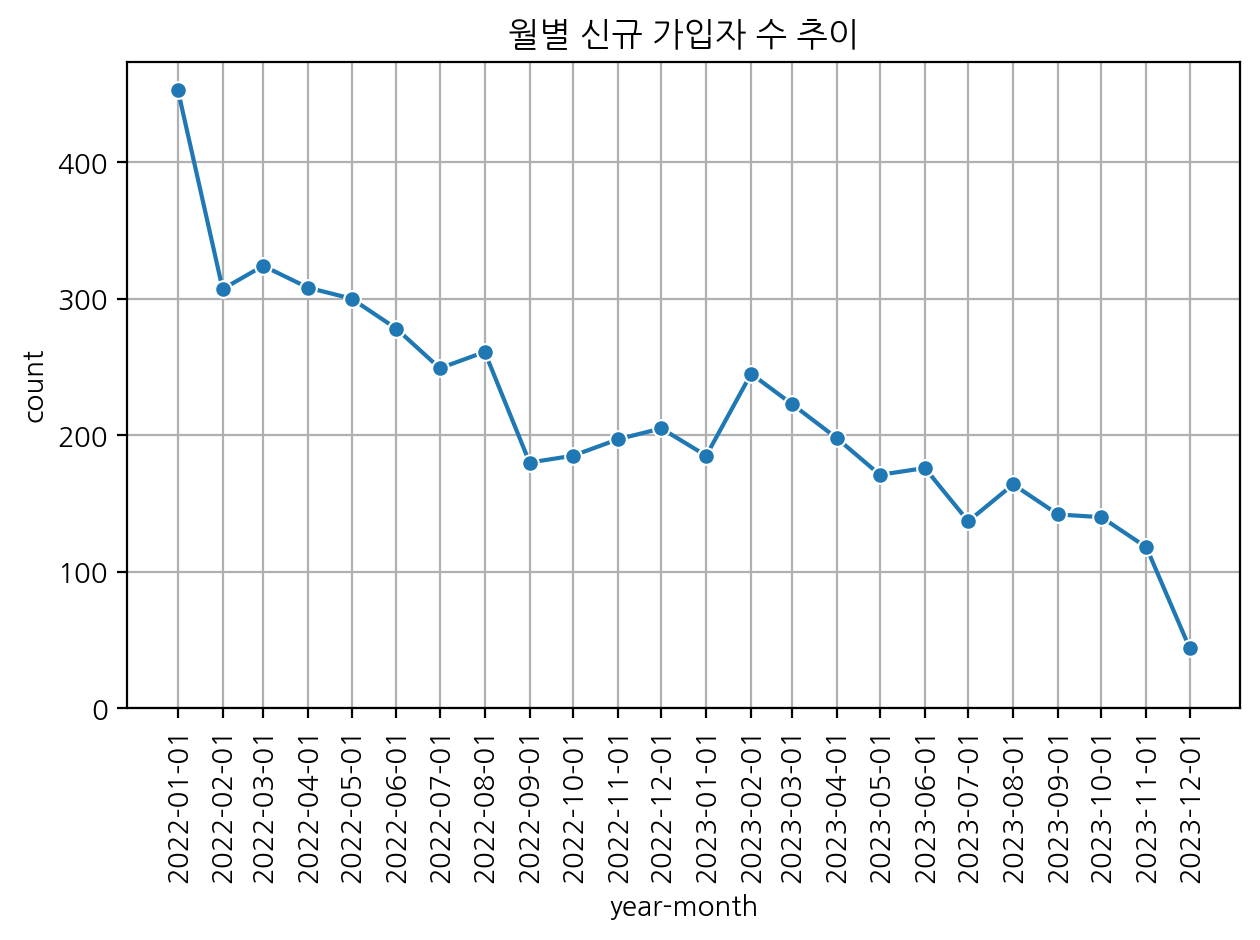

In [27]:
fig, ax = plt.subplots()
sns.lineplot(data=monthly_new_users, x='year-month', y='count', marker='o')
plt.title('월별 신규 가입자 수 추이')
plt.grid(True)
plt.xticks(ticks=monthly_new_users['year-month'].values, rotation=90)
plt.ylim(0)
plt.tight_layout()
plt.show()

월별 신규 가입자 수 추이 분석 결과,
- 신규 가입자는 지속적으로 감소하는 추세임을 확인했다.
- 이는 전환 유도를 통한 효율적인 유저 확보가 중요한 상황임을 시사한다.

## Activation

### 가입 후 첫 전환까지의 소요 일수 누적 비율 분석

In [28]:
# 지원 그룹 vs 비전환 그룹 리텐션
# 지원일
# 지원 시점 추출
log_ps = log_ps.sort_values(by='timestamp_parsed')
apply_condition = (log['URL'].str.startswith('api/jobs/id/apply')) | (log['URL'].str.startswith('jobs/id/apply'))
first_app_time = log_ps[apply_condition].groupby(by='user_uuid', as_index=False).first()
first_app_time = first_app_time[['user_uuid', 'timestamp_parsed']]
first_app_time.columns = ['user_uuid', 'first_app_time']

# 전체 데이터에 병합
log_ps = log_ps.merge(first_app_time, on='user_uuid', how='left')

In [29]:
# 전환까지의 소요 일수 누적 비율 계산
# 첫 전환까지 걸린 일수
log_ps.loc[:, 'days_to_convert'] = (log_ps['first_app_time'].dt.normalize() - log_ps['signup_time'].dt.normalize()).dt.days

# 유저별 데이터
user_df = (
    log_ps
    .drop_duplicates(subset='user_uuid')
    .loc[:, ['user_uuid', 'days_to_convert']]
)

# 누적 전환자 수
converted_users = user_df[user_df['days_to_convert'].notna()]
cum_conv = (
    converted_users['days_to_convert']
    .value_counts()
    .sort_index()
    .cumsum()
    .reset_index()
)
cum_conv.columns = ['days_to_convert', 'cum_count']

# 누적 전환 비율
total_users = user_df['user_uuid'].nunique()
cum_conv['ratio'] = cum_conv['cum_count'] / total_users


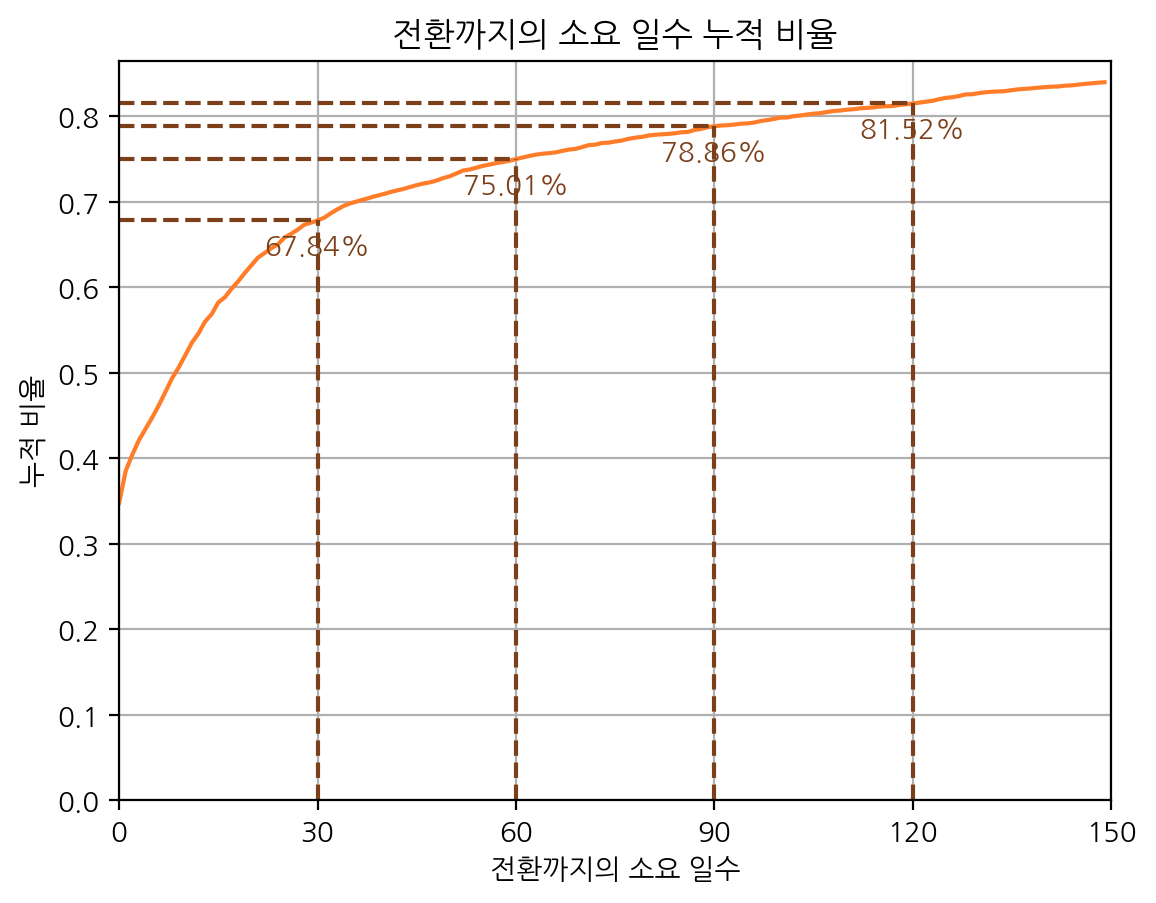

In [30]:
# 데이터 준비
cum_conv = cum_conv[cum_conv['days_to_convert'] <= 150]  # 150일 이내 기록만 추출

# 라인 그래프
fig, ax = plt.subplots()

sns.lineplot(data=cum_conv, x='days_to_convert', y='ratio', color='#FF7D29')
plt.title('전환까지의 소요 일수 누적 비율')
plt.xlabel('전환까지의 소요 일수')
plt.ylabel('누적 비율')
plt.grid(True)
plt.xticks(ticks=range(0, 151, 30), labels=range(0, 151, 30))
ax.set_xlim(left=0, right=150)
ax.set_ylim(0)

for day in [30, 60, 90, 120]:
    y_val = cum_conv[cum_conv['days_to_convert']==day]['ratio'].values[0]
    ax.hlines(y=y_val, xmin=0, xmax=day, colors='#7B4019', linestyles='--')
    ax.vlines(x=day, ymin=0, ymax=y_val, colors='#7B4019', linestyles='--')
    ax.text(day, y_val - 0.04, f"{y_val:.2%}", ha='center', color='#7B4019')

plt.show()

# 70% 이상의 사용자가 30일 이내에 전환됨

가입 후 첫 지원까지의 소요 일수 누적 비율 분석 결과, 
- 가입 후 1개월은 유저의 67.84%가 첫 전환을 경험하는 것으로 나타났다. 
- 이는 가입 후 1개월이 전환 유도에서의 골든 타임임을 시사한다.

### 전환 그룹 vs 비전환 그룹 가입 후 첫 7일 내 행동 지표 비교

In [31]:
log_firstweek = log_ps[log_ps['timestamp_parsed'] - log_ps['signup_time'] <= pd.Timedelta(days=7)]

# 추가 변수 1. 평균 체류 시간
# 세션별 시작, 종료 시간
session_times = log_firstweek.groupby(['user_uuid', 'session_id'])['timestamp_parsed'].agg(
    session_start='min',
    session_end='max'
).reset_index()

# 세션별 체류 시간(초)
session_times['session_duration_sec'] = (session_times['session_end'] - session_times['session_start']).dt.total_seconds()

# 세션 체류 시간 상한 적용(상한선 6시간)
session_times['session_duration_sec'] = session_times['session_duration_sec'].clip(upper=21600)

# 유저별 평균 체류 시간(초)
avg_stay_time = session_times.groupby(by='user_uuid')['session_duration_sec'].mean().reset_index(name='avg_stay_time_sec')

# 유의미한 세그먼트 기준 탐색 목적이므로, 평균적 경향 확인 필요 -> IQR 기준 이상치 제거
def remove_outliers_iqr(df, col):
		Q1 = df[col].quantile(0.25)
		Q3 = df[col].quantile(0.75)
		IQR = Q3 - Q1
	
		lower_fence = Q1 - 1.5*IQR
		upper_fence = Q3 + 1.5*IQR
	
		print(f"lower_fence: {lower_fence}, lower than lower_fence: {(df[col] < lower_fence).sum()}")
		print(f"upper_fence: {upper_fence}, higher than upper_fence: {(df[col] > upper_fence).sum()}")
		
		return df[(df[col] > lower_fence) & (df[col] < upper_fence)]

avg_stay_time = remove_outliers_iqr(avg_stay_time, 'avg_stay_time_sec')  

lower_fence: -10331.38374834576, lower than lower_fence: 0
upper_fence: 18675.401961481028, higher than upper_fence: 105


In [32]:
# 추가 변수 2. 총 페이지 뷰 수
page_views = log_firstweek[(log_firstweek['method']=='GET') & (~log_firstweek['URL'].str.startswith('api/'))]
page_views = page_views.groupby(by='user_uuid').size().reset_index(name='page_views_total')
page_views = remove_outliers_iqr(page_views, 'page_views_total')  # IQR 기준 이상치 제거

lower_fence: -66.5, lower than lower_fence: 0
upper_fence: 153.5, higher than upper_fence: 409


In [33]:
# 추가 변수 3. 개인 이력서 저장 여부
mask_resume = (log_firstweek['URL']=='api/users/id/resume/step2') & (log_firstweek['method']=='POST')
resume_users = log_firstweek[mask_resume]['user_uuid'].unique()
log_firstweek.loc[:, 'resume'] = log_firstweek['user_uuid'].isin(resume_users)

In [34]:
# 목표 변수: 1달 내 지원 여부(가입 후 일주일 데이터를 통한 1 - 2주차 타겟팅 전략의 목표로 삼기 적합)
log_firstmonth = log_ps[(log_ps['timestamp_parsed'].dt.normalize() - log_ps['signup_time'].dt.normalize()) <= pd.Timedelta(days=30)]
users_applied_month = log_firstmonth[log_firstmonth['URL']=='api/jobs/id/apply/step4']['user_uuid'].unique()

log_firstweek.loc[:, 'applied_within_month'] = log_firstweek['user_uuid'].isin(users_applied_month)

In [35]:
# 유저 요약 테이블 생성
user_stats = log_firstweek.groupby('user_uuid').agg(
    num_visit_days=('date', 'nunique'),             # 방문 일수
    keyword_searches=('searched_keyword', 'sum'),   # 키워드 검색 횟수(기업/공고)
    job_views=('viewed_job', 'sum'),                # 공고 열람 횟수
    bookmarks=('bookmarked', 'sum'),                # 공고 저장 횟수
    resume=('resume', 'max'),                       # 사전 등록 이력서 작성 여부
    applied=('applied_within_month', 'max')         # 1개월 내 지원 여부
).reset_index()

user_stats = pd.merge(user_stats, avg_stay_time, on='user_uuid', how='inner')
user_stats = pd.merge(user_stats, page_views, on='user_uuid', how='inner')

user_stats['resume'] = user_stats['resume'].astype(int)
user_stats['applied'] = user_stats['applied'].astype(int)

# 일주일 내 전환한 유저 분리
users_applied_week = log_firstweek[log_firstweek['URL']=='api/jobs/id/apply/step4']['user_uuid'].unique()
log_firstweek.loc[:, 'applied_within_week'] = log_firstweek['user_uuid'].isin(users_applied_week)

applied_in_week = user_stats[user_stats['user_uuid'].isin(users_applied_week)]
not_applied_in_week = user_stats[~user_stats['user_uuid'].isin(users_applied_week)]

In [36]:
# 전환 그룹의 가입 후 첫 7일 내 행동 지표
applied_in_week.describe()

,num_visit_days,keyword_searches,job_views,bookmarks,resume,applied,avg_stay_time_sec,page_views_total
count,1512.000000,1512.000000,1512.000000,1512.000000,1512.000000,1512.0,1512.000000,1512.000000
mean,3.279101,1.310185,9.663360,0.695106,0.326720,1.0,6801.322223,67.274471
std,1.699500,2.398367,10.116059,2.481759,0.469169,0.0,4134.122700,35.760371
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,127.972784,6.000000
25%,2.000000,0.000000,3.000000,0.000000,0.000000,1.0,3686.068979,38.000000
50%,3.000000,0.000000,7.000000,0.000000,0.000000,1.0,6249.043563,61.000000
75%,4.000000,2.000000,13.000000,0.000000,1.000000,1.0,9432.833204,93.000000
max,8.000000,22.000000,82.000000,45.000000,1.000000,1.0,18315.775411,153.000000


In [37]:
# 비전환 그룹의 가입 후 첫 7일 내 행동 지표
not_applied_in_week.describe()

,num_visit_days,keyword_searches,job_views,bookmarks,resume,applied,avg_stay_time_sec,page_views_total
count,3164.000000,3164.000000,3164.000000,3164.00000,3164.000000,3164.000000,3164.000000,3164.000000
mean,1.983249,0.872314,3.905499,0.50158,0.114096,0.368837,3008.547901,29.535714
std,1.317951,2.268314,8.333978,2.30005,0.317978,0.482566,3927.188191,26.903317
min,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,215.552602,11.000000
50%,2.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1116.780884,21.000000
75%,3.000000,1.000000,4.000000,0.00000,0.000000,1.000000,4610.398478,38.000000
max,8.000000,29.000000,104.000000,75.00000,1.000000,1.000000,18381.384992,152.000000


In [38]:
# 데이터 준비
applied_in_week['group'] = 'applied'  # 라벨링
not_applied_in_week['group'] = 'not_applied'

applied_in_week['group_size'] = len(applied_in_week)  # 그룹 크기
not_applied_in_week['group_size'] = len(not_applied_in_week)

week_concat = pd.concat([applied_in_week, not_applied_in_week])  # 합치기 
week_concat.drop(columns=['user_uuid'], inplace=True)
week_avg = week_concat.groupby(by='group', as_index=False).mean()
week_avg = week_avg[['group', 'group_size', 'applied', 'num_visit_days', 'avg_stay_time_sec', 'page_views_total',
                    'keyword_searches', 'job_views', 'bookmarks', 'resume']]

In [39]:
# 전환 그룹 vs 비전환 그룹 가입 후 첫 일주일 내 행동 지표 차이 검정

# 1. 일주일 내 방문 횟수, 키워드 검색 횟수, 공고 열람 횟수, 공고 저장 횟수, 총 페이지뷰 수: Mann-Whitney U 단측 검정
# 귀무 가설: 전환 그룹은 비전환 그룹에 비해 가입 후 일주일 내 방문 횟수, 키워드 검색 횟수, 공고 열람 횟수, 공고 저장 횟수, 총 페이지뷰 수가 같거나 작다
# 대립 가설: 전환 그룹은 비전환 그룹에 비해 가입 후 일주일 내 방문 횟수, 키워드 검색 횟수, 공고 열람 횟수, 공고 저장 횟수, 총 페이지뷰 수가 크다

# 데이터 준비
exclude_cols = ['resume', 'applied', 'group_size', 'group']
test_cols = [col for col in week_concat if col not in exclude_cols]

# Mann-Whitney U 단측 검정
for col in test_cols:
    applied_group = week_concat.loc[week_concat['group']=='applied', col]
    not_applied_group = week_concat.loc[week_concat['group']=='not_applied', col]
    stat, p = mannwhitneyu(applied_group, not_applied_group, alternative='greater')
    print(f"{col}의 p-value = {p:.4f}")
    
# 모든 지표에 대해 귀무가설 기각됨(p < 0.001)

num_visit_days의 p-value = 0.0000
keyword_searches의 p-value = 0.0000
job_views의 p-value = 0.0000
bookmarks의 p-value = 0.0000
avg_stay_time_sec의 p-value = 0.0000
page_views_total의 p-value = 0.0000


In [40]:
# 2. 사전 등록 이력서 작성 여부: 카이 제곱 검정
# 귀무 가설: 전환 그룹과 비전환 그룹은 사전 등록 이력서 작성률이 같다
# 대립 가설: 전환 그룹과 비전환 그룹은 사전 등록 이력서 작성률이 다르다

# 데이터 준비
chi2_data = week_concat.groupby(by='group').agg({'resume':'sum', 'group_size':'first'})
chi2_data.loc[:, 'no_resume'] = chi2_data['group_size'] - chi2_data['resume']
chi2_data.drop(columns='group_size', inplace=True)

# 카이 제곱 검정
chi2, p, dof, expected = chi2_contingency(chi2_data)

print(f"Chi-square statistic: {chi2:.4f}")
print(f"p-value: {p:.4f}")

# 귀무가설 기각됨(p < 0.001)

Chi-square statistic: 308.1367
p-value: 0.0000


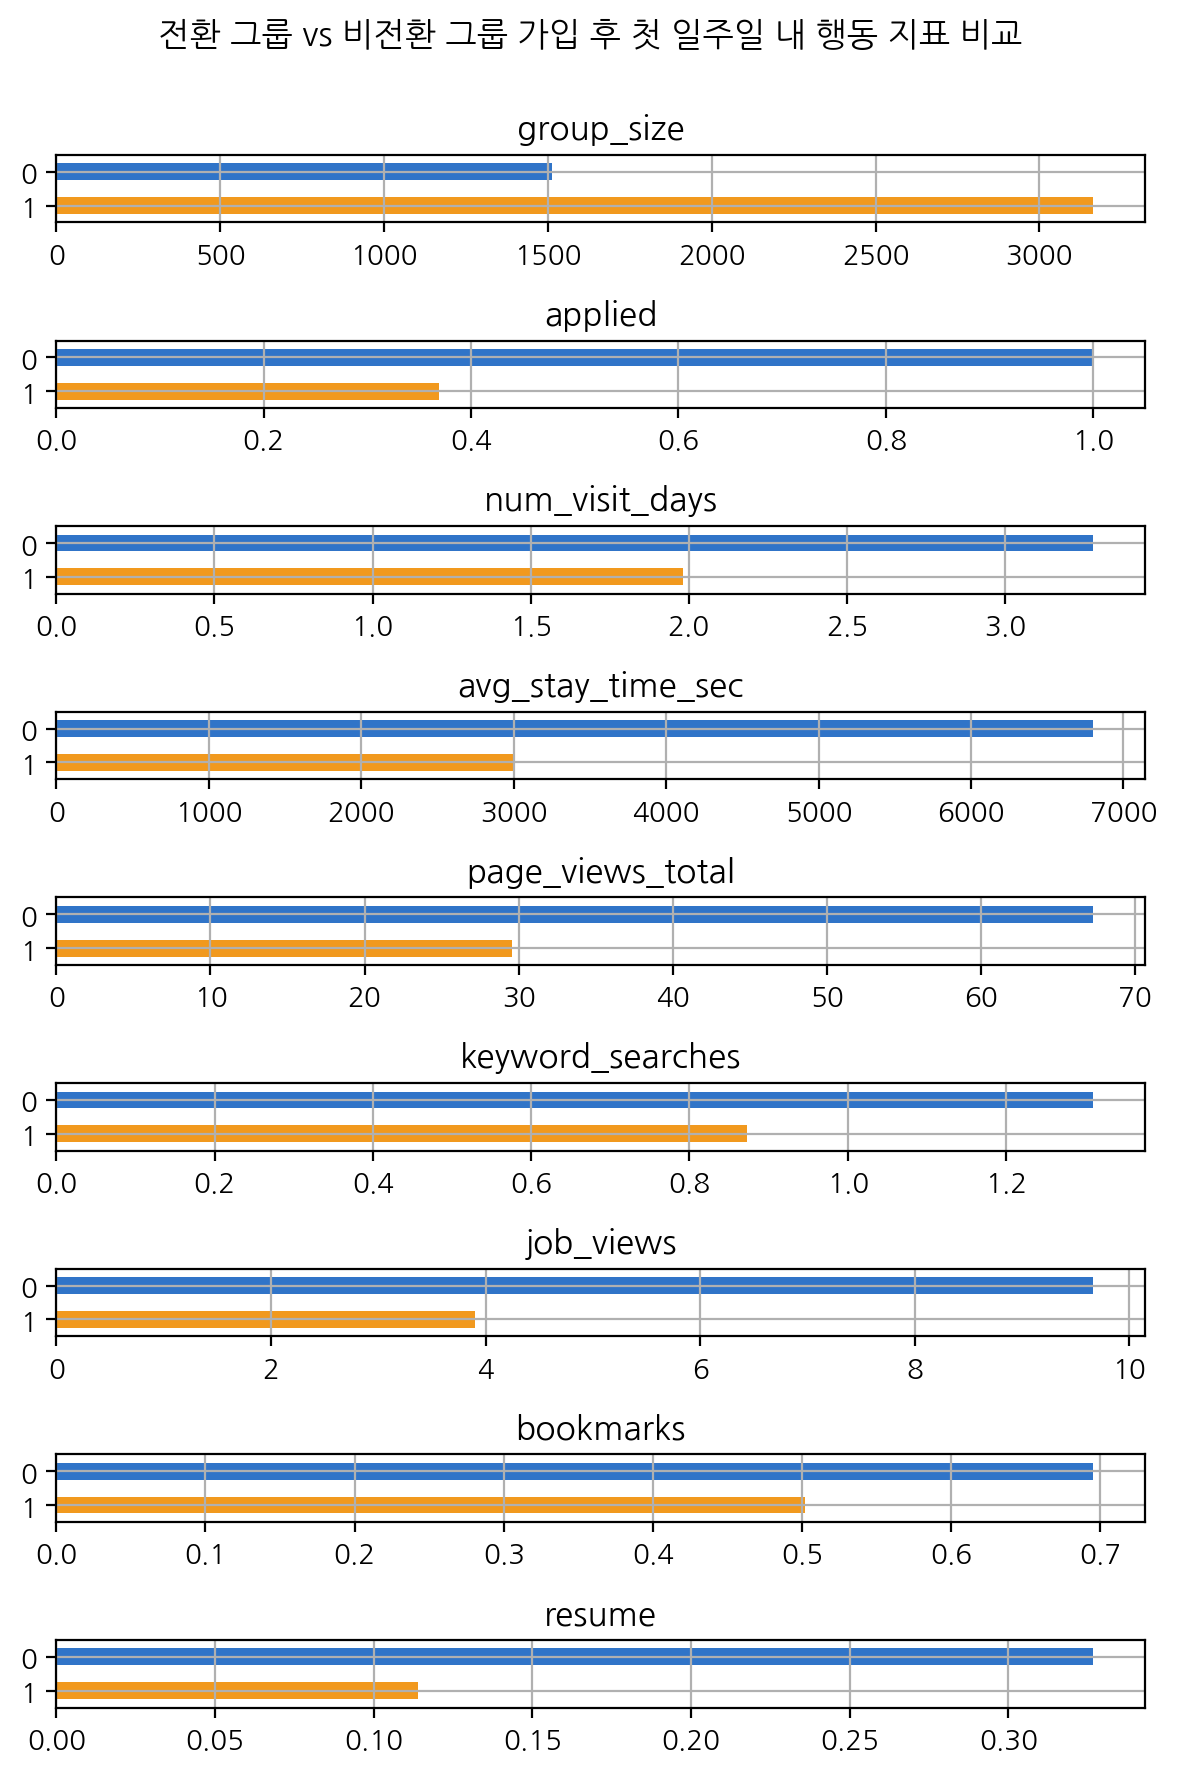

In [41]:
# 시각화
palette = [
     "#f1991e",
     "#3074c8"
]

fig, ax = plt.subplots(9, 1, figsize=(6, 9))
axes = ax.flatten()
for i, col in enumerate(week_avg.columns.drop('group')):
    week_avg[col].T.iloc[::-1].plot(kind='barh', color=palette, ax=axes[i])
    axes[i].set_title(f"{col}")
    axes[i].grid(True)

plt.suptitle('전환 그룹 vs 비전환 그룹 가입 후 첫 일주일 내 행동 지표 비교\n')
plt.tight_layout()
plt.show()

전환 그룹 vs 비전환 그룹 가입 후 1주일 내 활동 지표(두 그룹에서 평균 체류 시간(초), 총 페이지뷰 수, 방문 횟수, 키워드 검색 횟수(기업/공고), 공고 열람 횟수, 공고 저장 횟수, 사전 등록 이력서 작성 여부) 차이 비교 결과, 
- 맨-휘트니 U 검정 및 카이제곱 검정 결과 두 그룹에서 각 지표는 통계적으로 유의미하게 차이가 나타났다 (p < 0.001).
- 이를 통해 가입 후 1주일 내 행동 지표가 전환 여부와 유의미하게 관련됨 확인했다.

### 가입 후 첫 7일 내 행동 변수 중 전환을 예측하는 주요 변수 탐색

In [42]:
# 모델링
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

data = not_applied_in_week.drop(columns=['user_uuid', 'group'])
X=data.drop(columns='applied')
y=data['applied']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5, stratify=y)

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=5)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"accuracy score: {acc_rf:.3f}")

from sklearn.metrics import roc_auc_score
y_pred_prob = rf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC: {roc_auc:.4f}")

accuracy score: 0.668
ROC AUC: 0.6962


In [43]:
# 피처 중요도
importances = rf.feature_importances_
feat_importance = pd.Series(importances, index=X_train.columns)
feat_importance_sorted = feat_importance.sort_values(ascending=False)

print(feat_importance_sorted)

avg_stay_time_sec    0.422265
page_views_total     0.247338
job_views            0.112594
num_visit_days       0.091627
keyword_searches     0.060380
bookmarks            0.035241
resume               0.030555
group_size           0.000000
dtype: float64


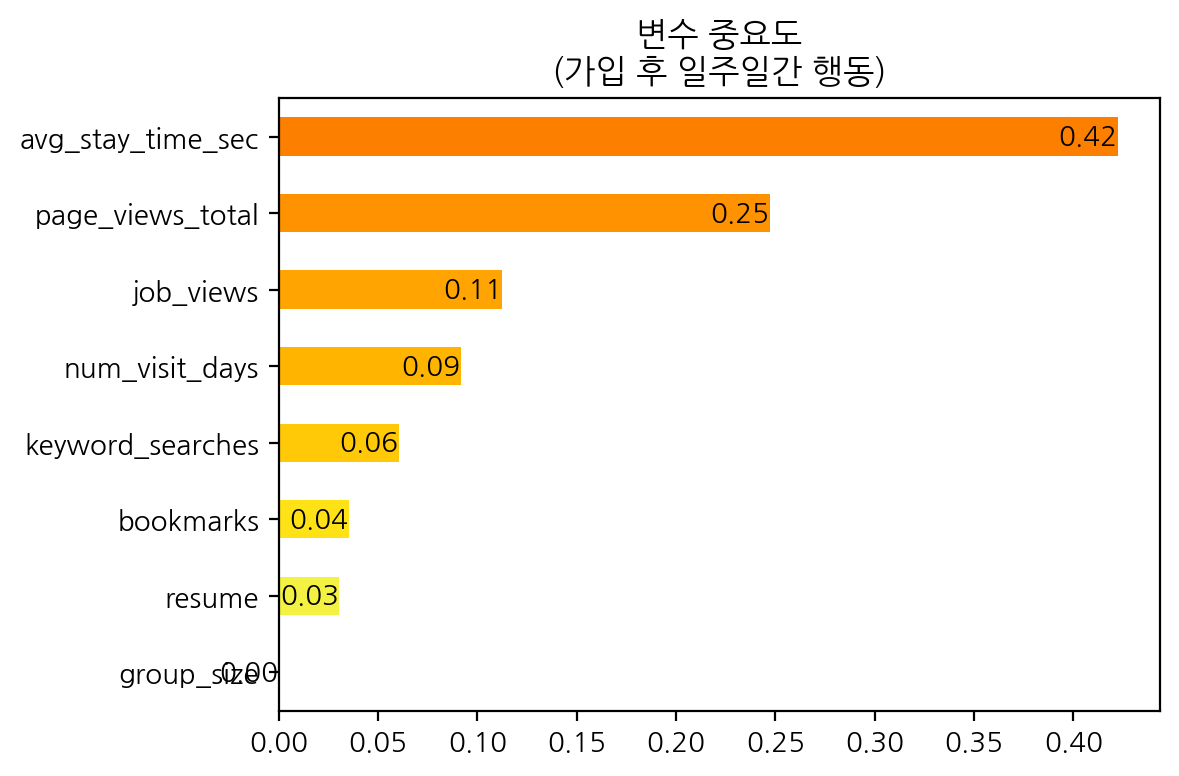

In [44]:
import matplotlib.cm as cm

# 컬러맵
n = len(feat_importance_sorted)
cmap = cm.get_cmap('Wistia', n)
colors = [cmap(i) for i in range(n)]

# 그래프
ax = feat_importance_sorted[::-1].plot(
    kind='barh',
    color=colors,
    figsize=(6, 4)
)

# 값 표시
for patch, value in zip(ax.patches, feat_importance_sorted[::-1]):
    ax.text(
        patch.get_width() - 0.03,    # 막대 오른쪽에 약간 띄워서
        patch.get_y() + patch.get_height()/2,
        f'{value:.2f}',
        va='center'
    )

ax.set_title('변수 중요도\n(가입 후 일주일간 행동)')
plt.tight_layout()
plt.show()

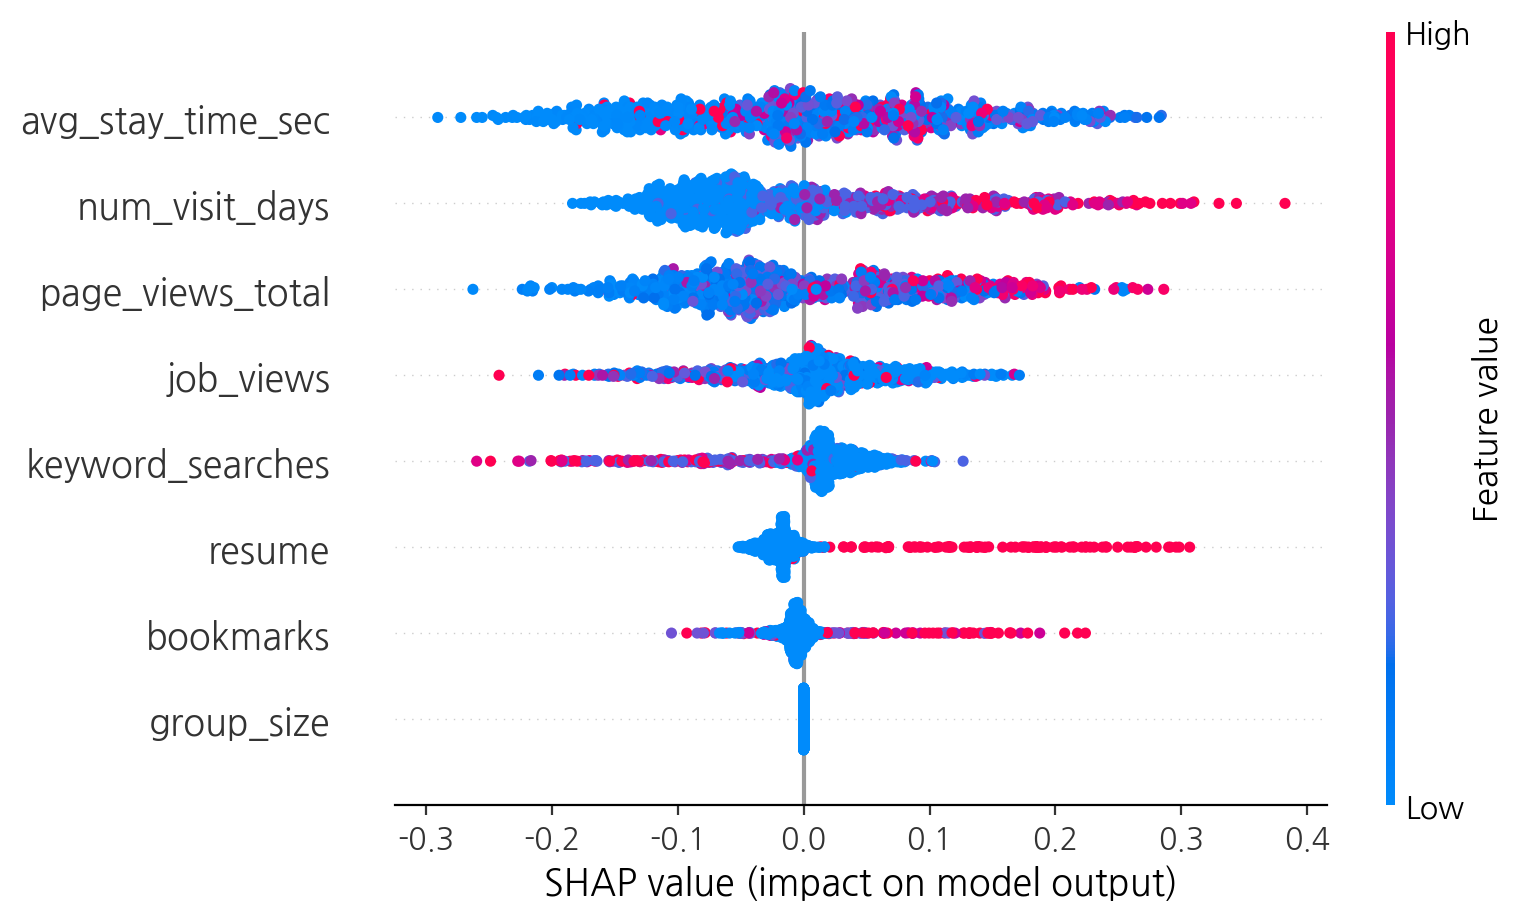

In [45]:
import shap

X_sample = X_train.sample(n=1000, random_state=42)

explainer = shap.TreeExplainer(rf, model_output='raw')
shap_values = explainer.shap_values(X_sample)

shap_values_class1 = shap_values[:, :, 1]

shap.summary_plot(shap_values_class1, X_sample)

RandomForestRegressor를 활용하여 가입 후 첫 1주일 내 활동 지표((가입 후 첫 7일 내) 방문 일수, 키워드 검색 횟수(기업/공고), 공고 열람 횟수, 공고 저장 횟수, 사전 등록 이력서 작성 여부, 평균 체류 시간(초), 총 페이지뷰 수)를 통해 전환 예측 모델링을 실시한 결과, 
1. 평균 체류 시간(초)(변수 중요도 0.43)과 총 페이지뷰 수(0.24)가 각각 가입 후 1개월 내 전환 여부 예측에 중요한 변수로 도출되었다. 
2. 또 SHAP 분석 결과, 
- 평균 체류 시간, 방문 일수, 페이지뷰 수, 공고 저장 여부는 전환 가능성을 높이는 방향으로, 
- 공고 열람 횟수와 키워드 검색 횟수는 전환 가능성을 낮추 방향으로 작용함을 확인했다.

## Retention, Revenue

*※ Revenue는 지표 부재로 Retention 결과를 통해 제한적으로 해석*

## 1개월 내 전환 그룹 vs 비전환그룹 방문 리텐션 비교

In [46]:
# 전환 vs 비전환
retention_6m_df = log_ps.copy()  

# 가입 연도/월, 로그 연도/월, month_offset 계산
retention_6m_df['signup_year']  = retention_6m_df['signup_time'].dt.year
retention_6m_df['signup_month'] = retention_6m_df['signup_time'].dt.to_period('M')
retention_6m_df['log_year']     = retention_6m_df['timestamp_parsed'].dt.year
retention_6m_df['log_month']    = retention_6m_df['timestamp_parsed'].dt.to_period('M')
retention_6m_df['month_offset'] = (retention_6m_df['log_month'] - retention_6m_df['signup_month']).apply(lambda x: x.n)
retention_6m_df['is_applied'] = retention_6m_df['first_app_time'].notna()

# 0 <= offset <= 6만 남기기
mask = (retention_6m_df['month_offset'] >= 0) & (retention_6m_df['month_offset'] <= 6)
df2 = retention_6m_df.loc[mask]


# 코호트별(연도+월) 가입자 수
cohort_sizes = (
    df2[['is_applied','user_uuid']]
      .drop_duplicates()
      .groupby('is_applied')
      .size()
      .rename('cohort_size')
)

# 방문 리텐션: offset별 고유 사용자 수 / cohort_size
visit_ret = (
    df2.groupby(['is_applied','month_offset'])['user_uuid']
       .nunique()
       .rename('n_visited')
       .reset_index()
       .set_index(['is_applied','month_offset'])
       .join(cohort_sizes, how='left')
)
visit_ret['visit_ret_pct'] = (visit_ret['n_visited'] / visit_ret['cohort_size'] * 100).round(1)

# offset=0은 100%로 덮어쓰기
visit_ret.loc[
    visit_ret.index.get_level_values('month_offset') == 0,
    'visit_ret_pct'
] = 100.0

visit_all = visit_ret[['visit_ret_pct']]  # 방문율만 추출

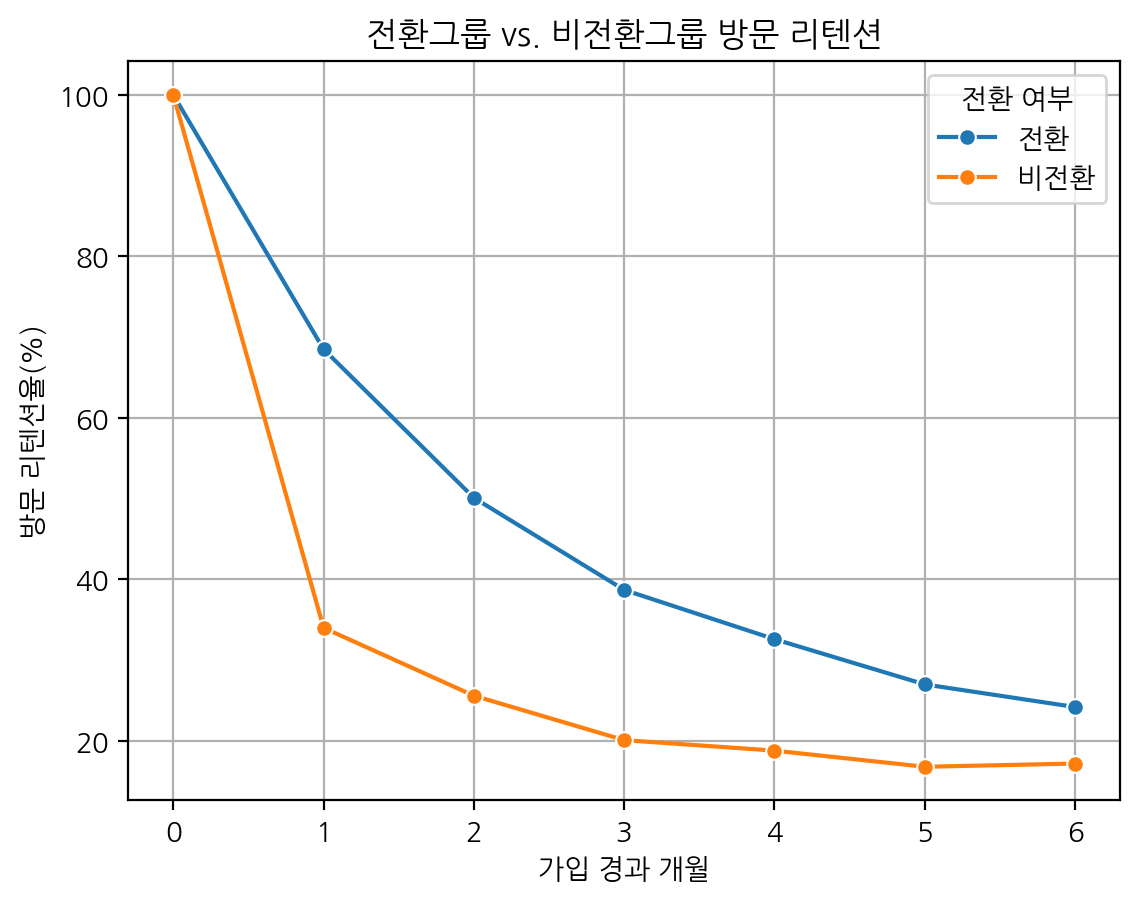

In [47]:
# 데이터 준비
visit_all.reset_index(inplace=True)
visit_all['is_applied'] = visit_all['is_applied'].map({True: '전환', False: '비전환'})  # 라벨링

# 라인 그래프
fig, ax = plt.subplots()

sns.lineplot(data=visit_all, x='month_offset', y='visit_ret_pct', hue='is_applied', hue_order=['전환', '비전환'], marker='o')
plt.title('전환그룹 vs. 비전환그룹 방문 리텐션')
plt.xlabel('가입 경과 개월')
plt.ylabel('방문 리텐션율(%)')
ax.legend(title='전환 여부')
plt.grid(True)

plt.show()

# 전환 그룹에서의 방문 리텐션이 비전환 그룹보다 높은 것으로 나타남

1개월 내 전환 그룹 vs 비전환그룹 방문 리텐션 비교 결과,
- 전환 그룹에서 리텐션이 더 높게 나타났다. 
- 이러한 결과는 가입 후 첫 1개월 내 전환이 유저의 장기적인 서비스 이용 가능성과 밀접하게 관련됨을 시사한다.
- 초기에 전환한 유저는 이후에도 플랫폼을 꾸준히 이용하고 평균 체류 시간과 총 페이지뷰 수가 증가해 광고 노출 기회가 확대될 가능성이 높으므로, 사용자 생애 가치(LTV) 또한 동반 상승할 수 있다.

## 신규 유저 지원 리텐션 코호트 분석

In [48]:
retention_df = log_ps.copy()

# 가입 연도/월, 로그 연도/월, month_offset 계산
retention_df['signup_year']  = retention_df['signup_time'].dt.year
retention_df['signup_month'] = retention_df['signup_time'].dt.to_period('M')
retention_df['log_year']     = retention_df['timestamp_parsed'].dt.year
retention_df['log_month']    = retention_df['timestamp_parsed'].dt.to_period('M')
retention_df['month_offset'] = ((retention_df['log_month'] - retention_df['signup_month'])).apply(lambda x: x.n)

# 동일 연도(log_year == signup_year) & offset ≥ 0만 남기기
mask = (retention_df['log_year'] == retention_df['signup_year']) & (retention_df['month_offset'] >= 0)
df2 = retention_df.loc[mask]

# 코호트별(연도+월) 가입자 수
cohort_sizes = (
    df2[['signup_year','signup_month','user_uuid']]
      .drop_duplicates()
      .groupby(['signup_year','signup_month'])
      .size()
      .rename('cohort_size')
)

# 방문 리텐션: offset별 고유 사용자 수 / cohort_size
visit_ret = (
    df2.groupby(['signup_year','signup_month','month_offset'])['user_uuid']
       .nunique()
       .rename('n_visited')
       .reset_index()
       .set_index(['signup_year','signup_month','month_offset'])
       .join(cohort_sizes, how='left')
)
visit_ret['visit_ret_pct'] = (visit_ret['n_visited'] / visit_ret['cohort_size'] * 100).round(1)

# 지원 리텐션: 동일 방식, URL에 'api/jobs/id/apply/step4' 포함
apply_ret = (
    df2[df2['URL'].str.contains('api/jobs/id/apply/step4', na=False)]
      .groupby(['signup_year','signup_month','month_offset'])['user_uuid']
      .nunique()
      .rename('n_applied')
      .reset_index()
      .set_index(['signup_year','signup_month','month_offset'])
      .join(cohort_sizes, how='left')
)
apply_ret['apply_ret_pct'] = (apply_ret['n_applied'] / apply_ret['cohort_size'] * 100).round(1)

# 가입 당월(offset=0)은 방문·지원 모두 100%
# (apply도 가입월에 지원 로깅이 있을 수 있으니, 강제로 100 처리)
months0 = cohort_sizes.reset_index()[['signup_year','signup_month']]
months0['month_offset'] = 0
months0['visit_ret_pct'] = 100.0
months0['apply_ret_pct'] = 100.0

visit_ret0 = months0.set_index(['signup_year','signup_month','month_offset'])[['visit_ret_pct']]
apply_ret0 = months0.set_index(['signup_year','signup_month','month_offset'])[['apply_ret_pct']]

# 결합 & 피벗
visit_all = pd.concat([visit_ret0, visit_ret[['visit_ret_pct']]], axis=0)
apply_all = pd.concat([apply_ret0, apply_ret[['apply_ret_pct']]], axis=0)

retention = pd.concat([visit_all, apply_all], axis=1).reset_index()

retention_summary = retention.pivot_table(
    index=['signup_year','signup_month'],
    columns='month_offset',
    values=['visit_ret_pct','apply_ret_pct']
).sort_index()

In [49]:
# 2022년 신규 가입자 지원 리텐션
app_2022 = retention_summary['apply_ret_pct'].xs(2022, level='signup_year')
app_2022.index.name = 'signup_month'
app_2022.columns.name = 'month_offset'

# 2023년 신규 가입자 지원 리텐션
app_2023 = retention_summary['apply_ret_pct'].xs(2023, level='signup_year')
app_2023.index.name = 'signup_month'
app_2023.columns.name = 'month_offset'

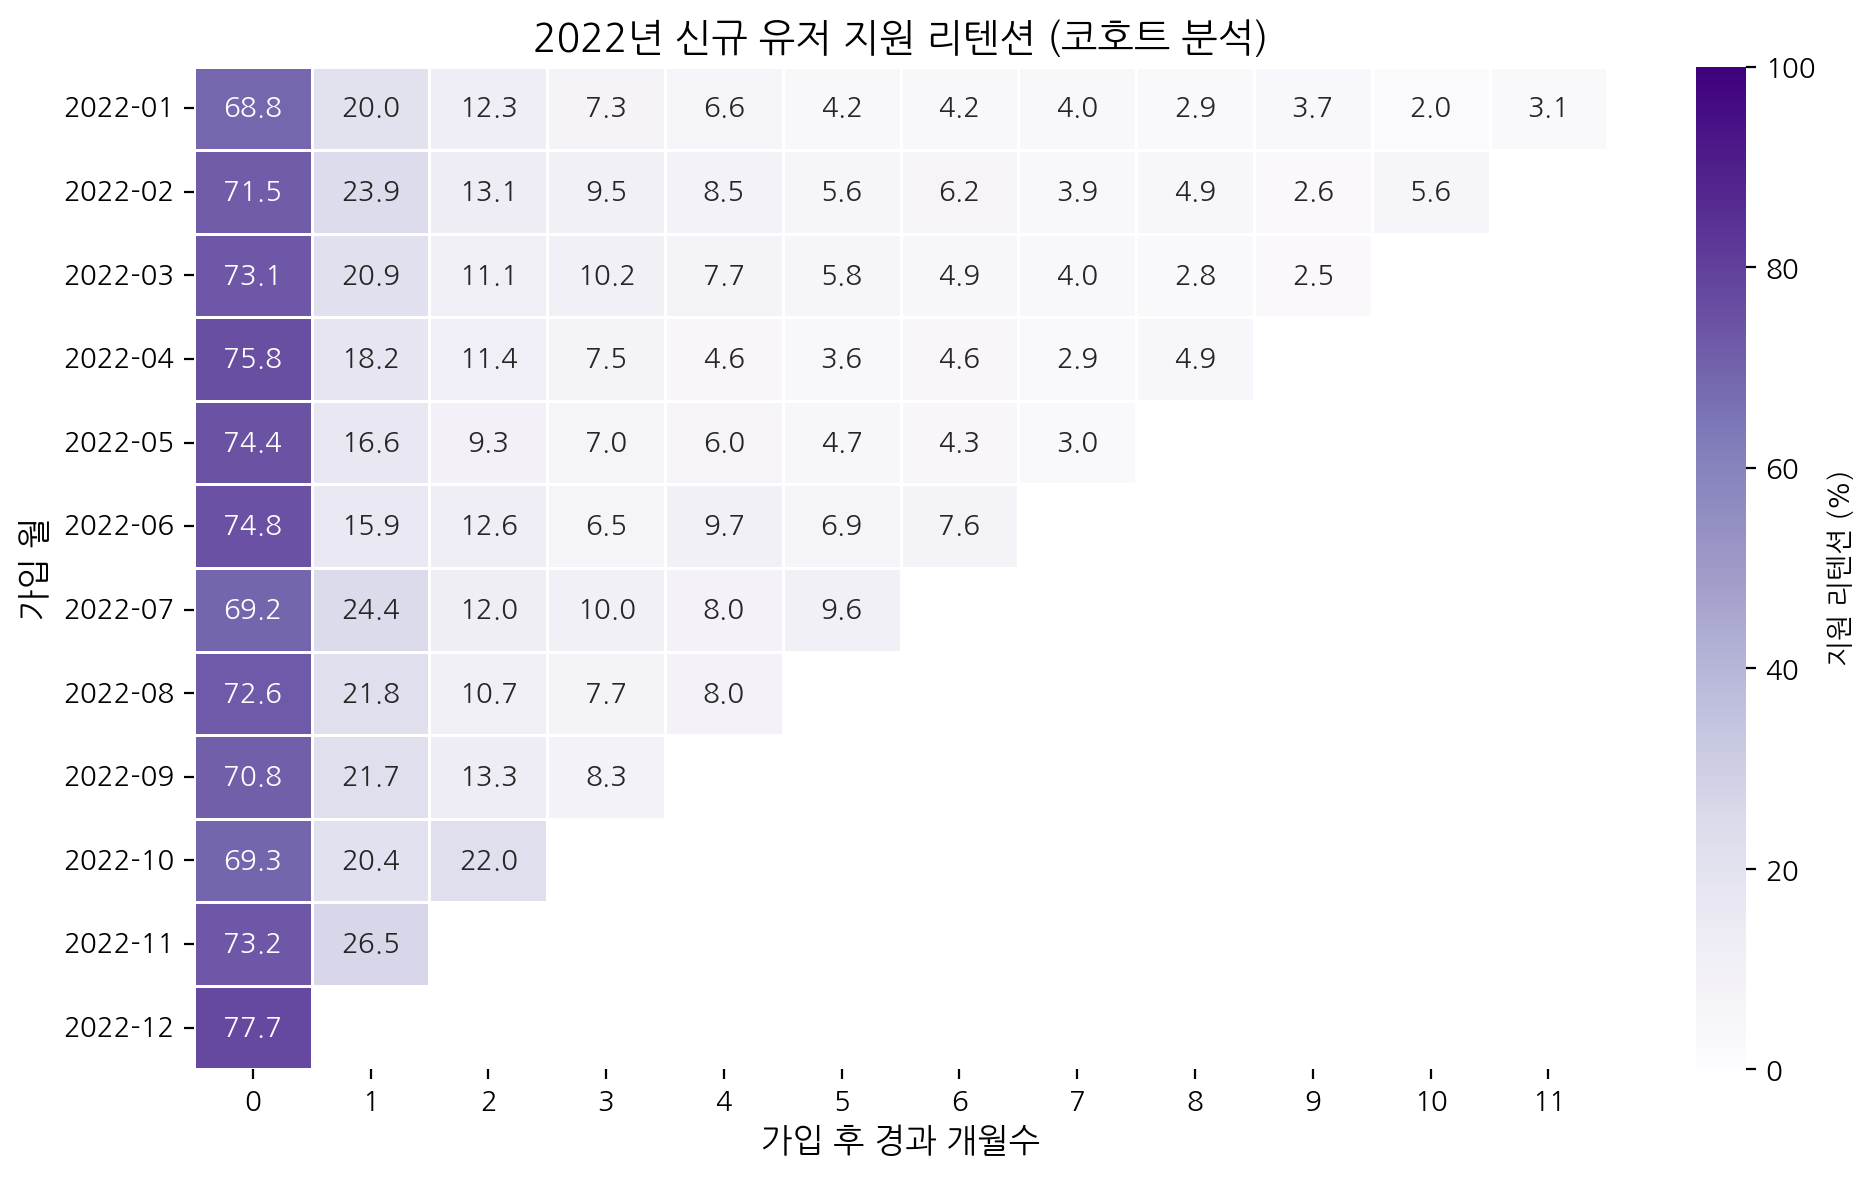

In [51]:
# 2022년 신규 가입자 지원 리텐션 시각화
min_val = 0.0
max_val = 100.0

plt.figure(figsize=(10, 6))
sns.heatmap(
    app_2022,
    annot=True,
    fmt=".1f",
    cmap="Purples",
    cbar_kws={'label': '지원 리텐션 (%)'},
    linewidths=0.5,
    linecolor='white',
    vmin=min_val,
    vmax=max_val
)
plt.title("2022년 신규 유저 지원 리텐션 (코호트 분석)", fontsize=14)
plt.xlabel("가입 후 경과 개월수", fontsize=12)
plt.ylabel("가입 월", fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

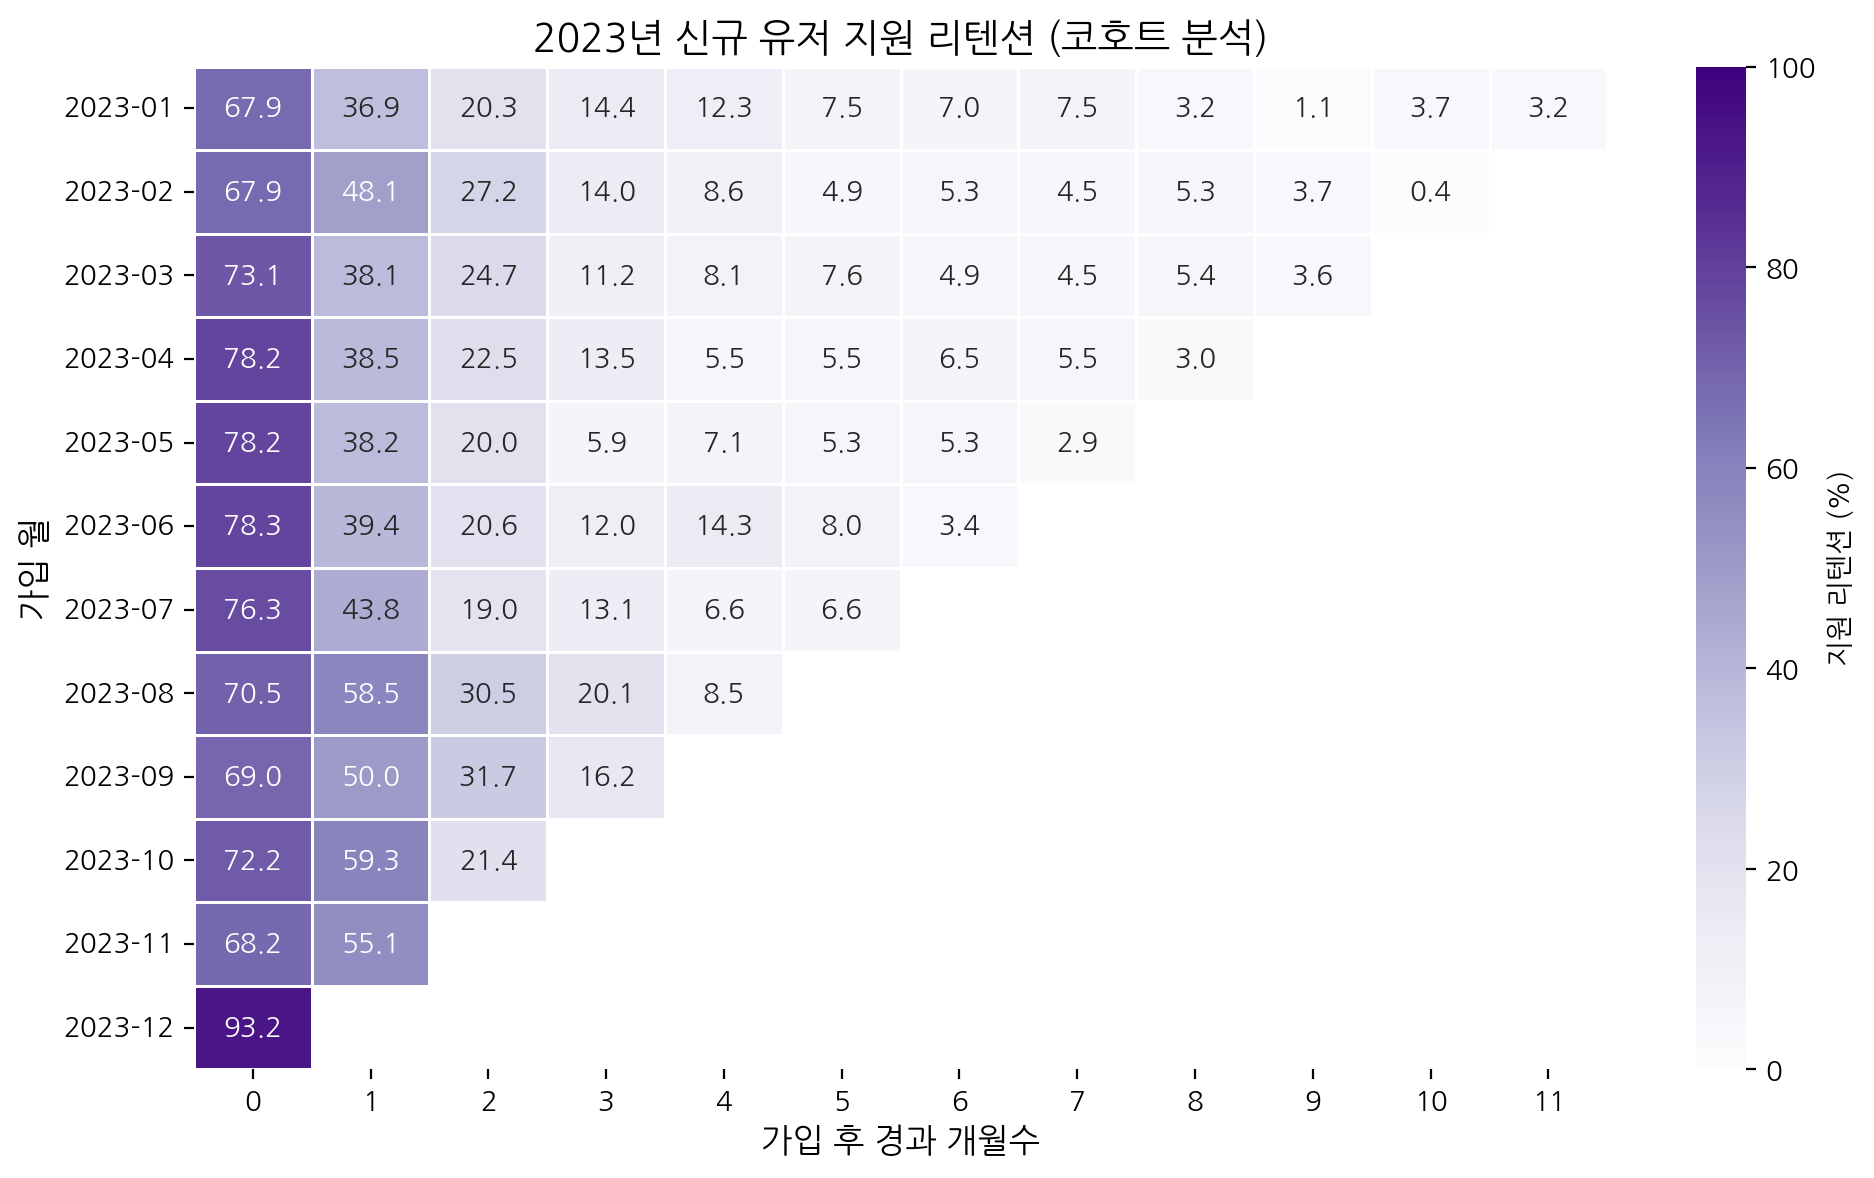

In [52]:
# 2023년 신규 가입자 지원 리텐션 시각화

plt.figure(figsize=(10, 6))
sns.heatmap(
    app_2023,
    annot=True,
    fmt=".1f",
    cmap="Purples",
    cbar_kws={'label': '지원 리텐션 (%)'},
    linewidths=0.5,
    linecolor='white',
    vmin=min_val,
    vmax=max_val
)
plt.title("2023년 신규 유저 지원 리텐션 (코호트 분석)", fontsize=14)
plt.xlabel("가입 후 경과 개월수", fontsize=12)
plt.ylabel("가입 월", fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

신규 유저 지원 리텐션 코호트 분석 결과,
- 최근 가입자일수록 지원 리텐션이 높아지는 추세가 확인되었다.
- 이는 최근 유입 유저가 전환 가능성이 높은 ‘질적 유저’일 가능성을 시사하며,
공고당 지원 수 증가 및 유료 서비스 전환률 상승으로 이어질 수 있어
Revenue 측면에서도 긍정적인 신호로 해석된다.

# 4. 세그먼트 분석

## 세그먼트 기준 탐색

In [53]:
# 총 페이지 뷰 수 경계 탐색
not_applied_in_week['page_views_total'].describe()

count    3164.000000
mean       29.535714
std        26.903317
min         1.000000
25%        11.000000
50%        21.000000
75%        38.000000
max       152.000000
Name: page_views_total, dtype: float64

In [54]:
# 구간 나누기
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 130, 140, 150]
not_applied_in_week['pageviews_bin'] = pd.cut(not_applied_in_week['page_views_total'], bins=bins)

# 구간별 전환율
conversion_rate = not_applied_in_week.groupby('pageviews_bin')['applied'].mean()
print(conversion_rate)

# 50 이하는 저활동군, 50 초과는 고활동군으로 정의

pageviews_bin
(0, 10]       0.203463
(10, 20]      0.300571
(20, 30]      0.409894
(30, 40]      0.422442
(40, 50]      0.404762
(50, 60]      0.568345
(60, 70]      0.607843
(70, 80]      0.690141
(80, 90]      0.666667
(90, 100]     0.652174
(100, 120]    0.625000
(120, 130]    0.533333
(130, 140]    0.476190
(140, 150]    0.700000
Name: applied, dtype: float64


In [55]:
# 평균 체류 시간 경계 탐색
not_applied_in_week['avg_stay_time_sec'].describe()

count     3164.000000
mean      3008.547901
std       3927.188191
min          0.000000
25%        215.552602
50%       1116.780884
75%       4610.398478
max      18381.384992
Name: avg_stay_time_sec, dtype: float64

In [56]:
# 구간 나누기
bins = [0, 500, 1000, 1500, 2000, 2500, 3000, 5000, 7500, 10000, 20000]
not_applied_in_week['avg_stay_time_bin'] = pd.cut(not_applied_in_week['avg_stay_time_sec'], bins=bins)

# 구간별 전환율
conversion_rate = not_applied_in_week.groupby('avg_stay_time_bin')['applied'].mean()
print(conversion_rate)

# 1500 이하는 저활동군, 1500 초과는 고활동군으로 정의

avg_stay_time_bin
(0, 500]          0.212224
(500, 1000]       0.376147
(1000, 1500]      0.412935
(1500, 2000]      0.493750
(2000, 2500]      0.475806
(2500, 3000]      0.449438
(3000, 5000]      0.538217
(5000, 7500]      0.526316
(7500, 10000]     0.583333
(10000, 20000]    0.376923
Name: applied, dtype: float64


In [ ]:
mask_1 = (not_applied_in_week['avg_stay_time_sec'] >= 1500) & (not_applied_in_week['page_views_total'] >= 30)
mask_2 = (not_applied_in_week['avg_stay_time_sec'] >= 1500) & (not_applied_in_week['page_views_total'] < 30)
mask_3 = (not_applied_in_week['avg_stay_time_sec'] < 1500) & (not_applied_in_week['page_views_total'] >= 30)
mask_4 = (not_applied_in_week['avg_stay_time_sec'] < 1500) & (not_applied_in_week['page_views_total'] < 30)

len(not_applied_in_week[mask_1]), len(not_applied_in_week[mask_2]), len(not_applied_in_week[mask_3]), len(not_applied_in_week[mask_4])

(843, 581, 233, 1507)

## 세그먼트 분류 (기준: 가입 후 일주일 활동)

```
- 규칙 기반 세그먼트 구성
    - 분석 대상 전체 중, 가입 후 1주일 내 전환을 완료한 유저 1,484명은 별도로 분리하여 세그먼트 1로 정의했다.
    - 나머지 3,321명에 대해 랜덤 포레스트 결과 기반 주요 변수(평균 체류 시간, 페이지뷰 수)를 활용해 규칙 기반 4개 세그먼트로 분류함
    - → 총 5개 세그먼트 구성
- 규칙 설정 근거:
    - 기준 변수: 랜덤 포레스트 결과, 평균 체류 시간(초)과 총 페이지뷰 수가 가장 중요한 예측 변수로 도출됨
    - 경계값 설정:
        - 평균 체류 시간: 1500초
        - 총 페이지뷰 30
        - ※ 페이지뷰의 경우, 경계값을 50으로 설정할 경우 세그먼트 간 쏠림 현상이 심해짐            
        (예: 세그먼트 A = 1707명, 세그먼트 C = 59명)
        - 페이지뷰에 따른 구간별 전환률이 완만히 상승해 뚜렷한 경계값은 없지만, 분석 타당성과 마케팅 실무 적용성을 고려하여 충분한 샘플 수를 확보할 수 있는 30 기준으로 설정
```

In [58]:
# 유저 요약 테이블 생성
user_stats_wk = log_firstweek.groupby('user_uuid').agg(
    num_visit_days=('date', 'nunique'),                 # 방문 일수
    keyword_searches=('searched_keyword', 'sum'),       # 키워드 검색 횟수(기업/공고)
    job_views=('viewed_job', 'sum'),                    # 공고 열람 횟수
    bookmarks=('bookmarked', 'sum'),                    # 공고 저장 횟수
    resume=('resume', 'max'),                           # 사전 등록 이력서 작성 여부
    applied=('applied_within_month', 'max'),            # KPI(1개월 내 지원 여부)
    total_app=('applied', 'sum')                        # 지원 횟수
).reset_index()

user_stats_wk['resume'] = user_stats_wk['resume'].astype(int)
user_stats_wk['applied'] = user_stats_wk['applied'].astype(int)

# 평균 체류 시간(초), 총 페이지뷰 수
user_stats_wk = pd.merge(user_stats_wk, avg_stay_time, on='user_uuid', how='inner')
user_stats_wk = pd.merge(user_stats_wk, page_views, on='user_uuid', how='inner')

# 재방문 일수
user_stats_wk['num_visit_days'] = user_stats_wk['num_visit_days'] - 1
user_stats_wk.rename(columns={'num_visit_days': 'revisit_counts'}, inplace=True)

# 재방문 여부
user_stats_wk['revisited'] = user_stats_wk['revisit_counts'] > 0

# 재지원 횟수
user_stats_wk['total_app'] = np.where(user_stats_wk['total_app'] > 0, user_stats_wk['total_app'] - 1, user_stats_wk['total_app'])
user_stats_wk.rename(columns={'total_app': 'reapply_counts'}, inplace=True)

# 재지원 여부
user_stats_wk['reapplied'] = user_stats_wk['reapply_counts'] > 0

# 7D 리텐션 여부
log_firstmonth['days_since'] = (log_firstmonth['timestamp_parsed'].dt.normalize() - log_firstmonth['signup_time'].dt.normalize()).dt.days
ret_users = log_firstmonth[log_firstmonth['days_since']==7]['user_uuid'].unique()

user_stats_wk['7D_retention'] = 0
user_stats_wk.loc[user_stats_wk['user_uuid'].isin(ret_users), '7D_retention'] = 1

In [59]:
user_stats_wk = user_stats_wk[['user_uuid', 
                                'applied',            # KPI
                                'revisited',          # 관여도 지표
                                'revisit_counts',     
                                '7D_retention',       
                                'reapplied',         
                                'reapply_counts',     
                                'avg_stay_time_sec',  # 세그먼트 기준
                                'page_views_total',
                                'keyword_searches',   # 행동 지표
                                'job_views', 
                                'bookmarks', 
                                'resume']]

In [60]:
# 일주일 내 전환한 유저 분리
users_applied_week = log_firstweek[log_firstweek['URL']=='api/jobs/id/apply/step4']['user_uuid'].unique()
log_firstweek.loc[:, 'applied_within_week'] = log_firstweek['user_uuid'].isin(users_applied_week)

app_wk = user_stats_wk[user_stats_wk['user_uuid'].isin(users_applied_week)]
napp_wk = user_stats_wk[~user_stats_wk['user_uuid'].isin(users_applied_week)]

In [61]:
# 일주일 내 전환 세그먼트
app_wk_users = app_wk['user_uuid'].unique()
app_wk.describe()

,applied,revisit_counts,7D_retention,reapply_counts,avg_stay_time_sec,page_views_total,keyword_searches,job_views,bookmarks,resume
count,1512.0,1512.000000,1512.000000,1512.000000,1512.000000,1512.000000,1512.000000,1512.000000,1512.000000,1512.000000
mean,1.0,2.279101,0.270503,0.685847,6801.322223,67.274471,1.310185,9.663360,0.695106,0.326720
std,0.0,1.699500,0.444366,1.559705,4134.122700,35.760371,2.398367,10.116059,2.481759,0.469169
min,1.0,0.000000,0.000000,0.000000,127.972784,6.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,1.000000,0.000000,0.000000,3686.068979,38.000000,0.000000,3.000000,0.000000,0.000000
50%,1.0,2.000000,0.000000,0.000000,6249.043563,61.000000,0.000000,7.000000,0.000000,0.000000
75%,1.0,3.000000,1.000000,1.000000,9432.833204,93.000000,2.000000,13.000000,0.000000,1.000000
max,1.0,7.000000,1.000000,16.000000,18315.775411,153.000000,22.000000,82.000000,45.000000,1.000000


In [62]:
# 일주일 내 미전환, 평균 체류 시간 >= 1500초, 페이지뷰 >= 30 세그먼트
seg_a_wk = napp_wk[mask_1]
seg_a_users = seg_a_wk['user_uuid'].unique()
seg_a_wk.describe()

,applied,revisit_counts,7D_retention,reapply_counts,avg_stay_time_sec,page_views_total,keyword_searches,job_views,bookmarks,resume
count,843.000000,843.000000,843.000000,843.0,843.000000,843.000000,843.000000,843.000000,843.000000,843.000000
mean,0.546856,2.188612,0.346382,0.0,6403.773349,62.559905,2.028470,9.708185,1.334520,0.265718
std,0.498095,1.581894,0.476099,0.0,3791.970074,28.869510,3.589592,13.265972,4.012993,0.441977
min,0.000000,0.000000,0.000000,0.0,1506.922885,30.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.0,3344.395126,40.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,2.000000,0.000000,0.0,5456.326494,55.000000,0.000000,5.000000,0.000000,0.000000
75%,1.000000,3.000000,1.000000,0.0,8742.247914,78.000000,2.000000,14.000000,1.000000,1.000000
max,1.000000,7.000000,1.000000,0.0,18381.384992,152.000000,29.000000,104.000000,75.000000,1.000000


In [63]:
# 일주일 내 미전환, 평균 체류 시간 >= 1500초, 페이지뷰 < 30 세그먼트
seg_b_wk = napp_wk[mask_2]
seg_b_users = seg_b_wk['user_uuid'].unique()
seg_b_wk.describe()

,applied,revisit_counts,7D_retention,reapply_counts,avg_stay_time_sec,page_views_total,keyword_searches,job_views,bookmarks,resume
count,581.000000,581.000000,581.000000,581.0,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000
mean,0.423408,1.006885,0.148021,0.0,5891.306359,19.327022,0.304647,1.884682,0.194492,0.110155
std,0.494525,1.032216,0.355426,0.0,4157.727882,6.569767,0.891606,3.270367,0.916348,0.313353
min,0.000000,0.000000,0.000000,0.0,1501.146656,2.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.0,2327.927208,14.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.0,4695.610541,21.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,2.000000,0.000000,0.0,8211.040138,25.000000,0.000000,3.000000,0.000000,0.000000
max,1.000000,5.000000,1.000000,0.0,18269.236710,29.000000,9.000000,20.000000,13.000000,1.000000


In [64]:
# 일주일 내 미전환, 평균 체류 시간 < 1500초, 페이지뷰 >= 30 세그먼트
seg_c_wk = napp_wk[mask_3]
seg_c_users = seg_c_wk['user_uuid'].unique()
seg_c_wk.describe()

,applied,revisit_counts,7D_retention,reapply_counts,avg_stay_time_sec,page_views_total,keyword_searches,job_views,bookmarks,resume
count,233.000000,233.000000,233.000000,233.0,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000
mean,0.373391,1.175966,0.214592,0.0,780.487087,43.566524,1.789700,6.167382,0.699571,0.158798
std,0.484746,1.109880,0.411423,0.0,405.172719,14.187054,2.782872,7.798229,2.066742,0.366275
min,0.000000,0.000000,0.000000,0.0,23.232527,30.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.0,455.277288,33.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.0,727.560249,39.000000,1.000000,4.000000,0.000000,0.000000
75%,1.000000,2.000000,0.000000,0.0,1168.489784,49.000000,3.000000,10.000000,0.000000,0.000000
max,1.000000,5.000000,1.000000,0.0,1494.747941,115.000000,21.000000,44.000000,18.000000,1.000000


In [65]:
# 일주일 내 미전환, 평균 체류 시간 < 1500초, 페이지뷰 < 30 세그먼트
seg_d_wk = napp_wk[mask_4]
seg_d_users = seg_d_wk['user_uuid'].unique()
seg_d_wk.describe()

,applied,revisit_counts,7D_retention,reapply_counts,avg_stay_time_sec,page_views_total,keyword_searches,job_views,bookmarks,resume
count,1507.000000,1507.000000,1507.00000,1507.0,1507.000000,1507.000000,1507.000000,1507.000000,1507.000000,1507.000000
mean,0.247512,0.270073,0.06503,0.0,342.377000,12.828799,0.302588,1.088918,0.123424,0.023889
std,0.431710,0.566366,0.24666,0.0,360.456938,6.789465,0.880669,2.200158,0.742847,0.152753
min,0.000000,0.000000,0.00000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.00000,0.0,75.808774,8.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.00000,0.0,206.612712,12.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.00000,0.0,487.573041,17.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,5.000000,1.00000,0.0,1493.381782,29.000000,8.000000,21.000000,15.000000,1.000000


In [66]:
# 세그먼트 라벨링
app_wk['seg'] = '1'
seg_a_wk['seg'] = '2'
seg_b_wk['seg'] = '3'
seg_c_wk['seg'] = '4'
seg_d_wk['seg'] = '5'

# 세그먼트 크기
app_wk['segment_size'] = len(app_wk)
seg_a_wk['segment_size'] = len(seg_a_wk)
seg_b_wk['segment_size'] = len(seg_b_wk)
seg_c_wk['segment_size'] = len(seg_c_wk)
seg_d_wk['segment_size'] = len(seg_d_wk)

# 합치기 
user_stats_wk_concat = pd.concat([app_wk, seg_a_wk, seg_b_wk, seg_c_wk, seg_d_wk])
user_stats_wk_sum = user_stats_wk_concat.drop(columns='user_uuid').groupby(by='seg', as_index=False).mean()

# 컬럼 순서 재지정
user_stats_wk_sum = user_stats_wk_sum[['segment_size', 'seg', 'applied', 'revisited', 'revisit_counts', '7D_retention',
       'reapplied', 'reapply_counts', 'avg_stay_time_sec', 'page_views_total', 'keyword_searches', 'job_views', 
       'bookmarks', 'resume']]

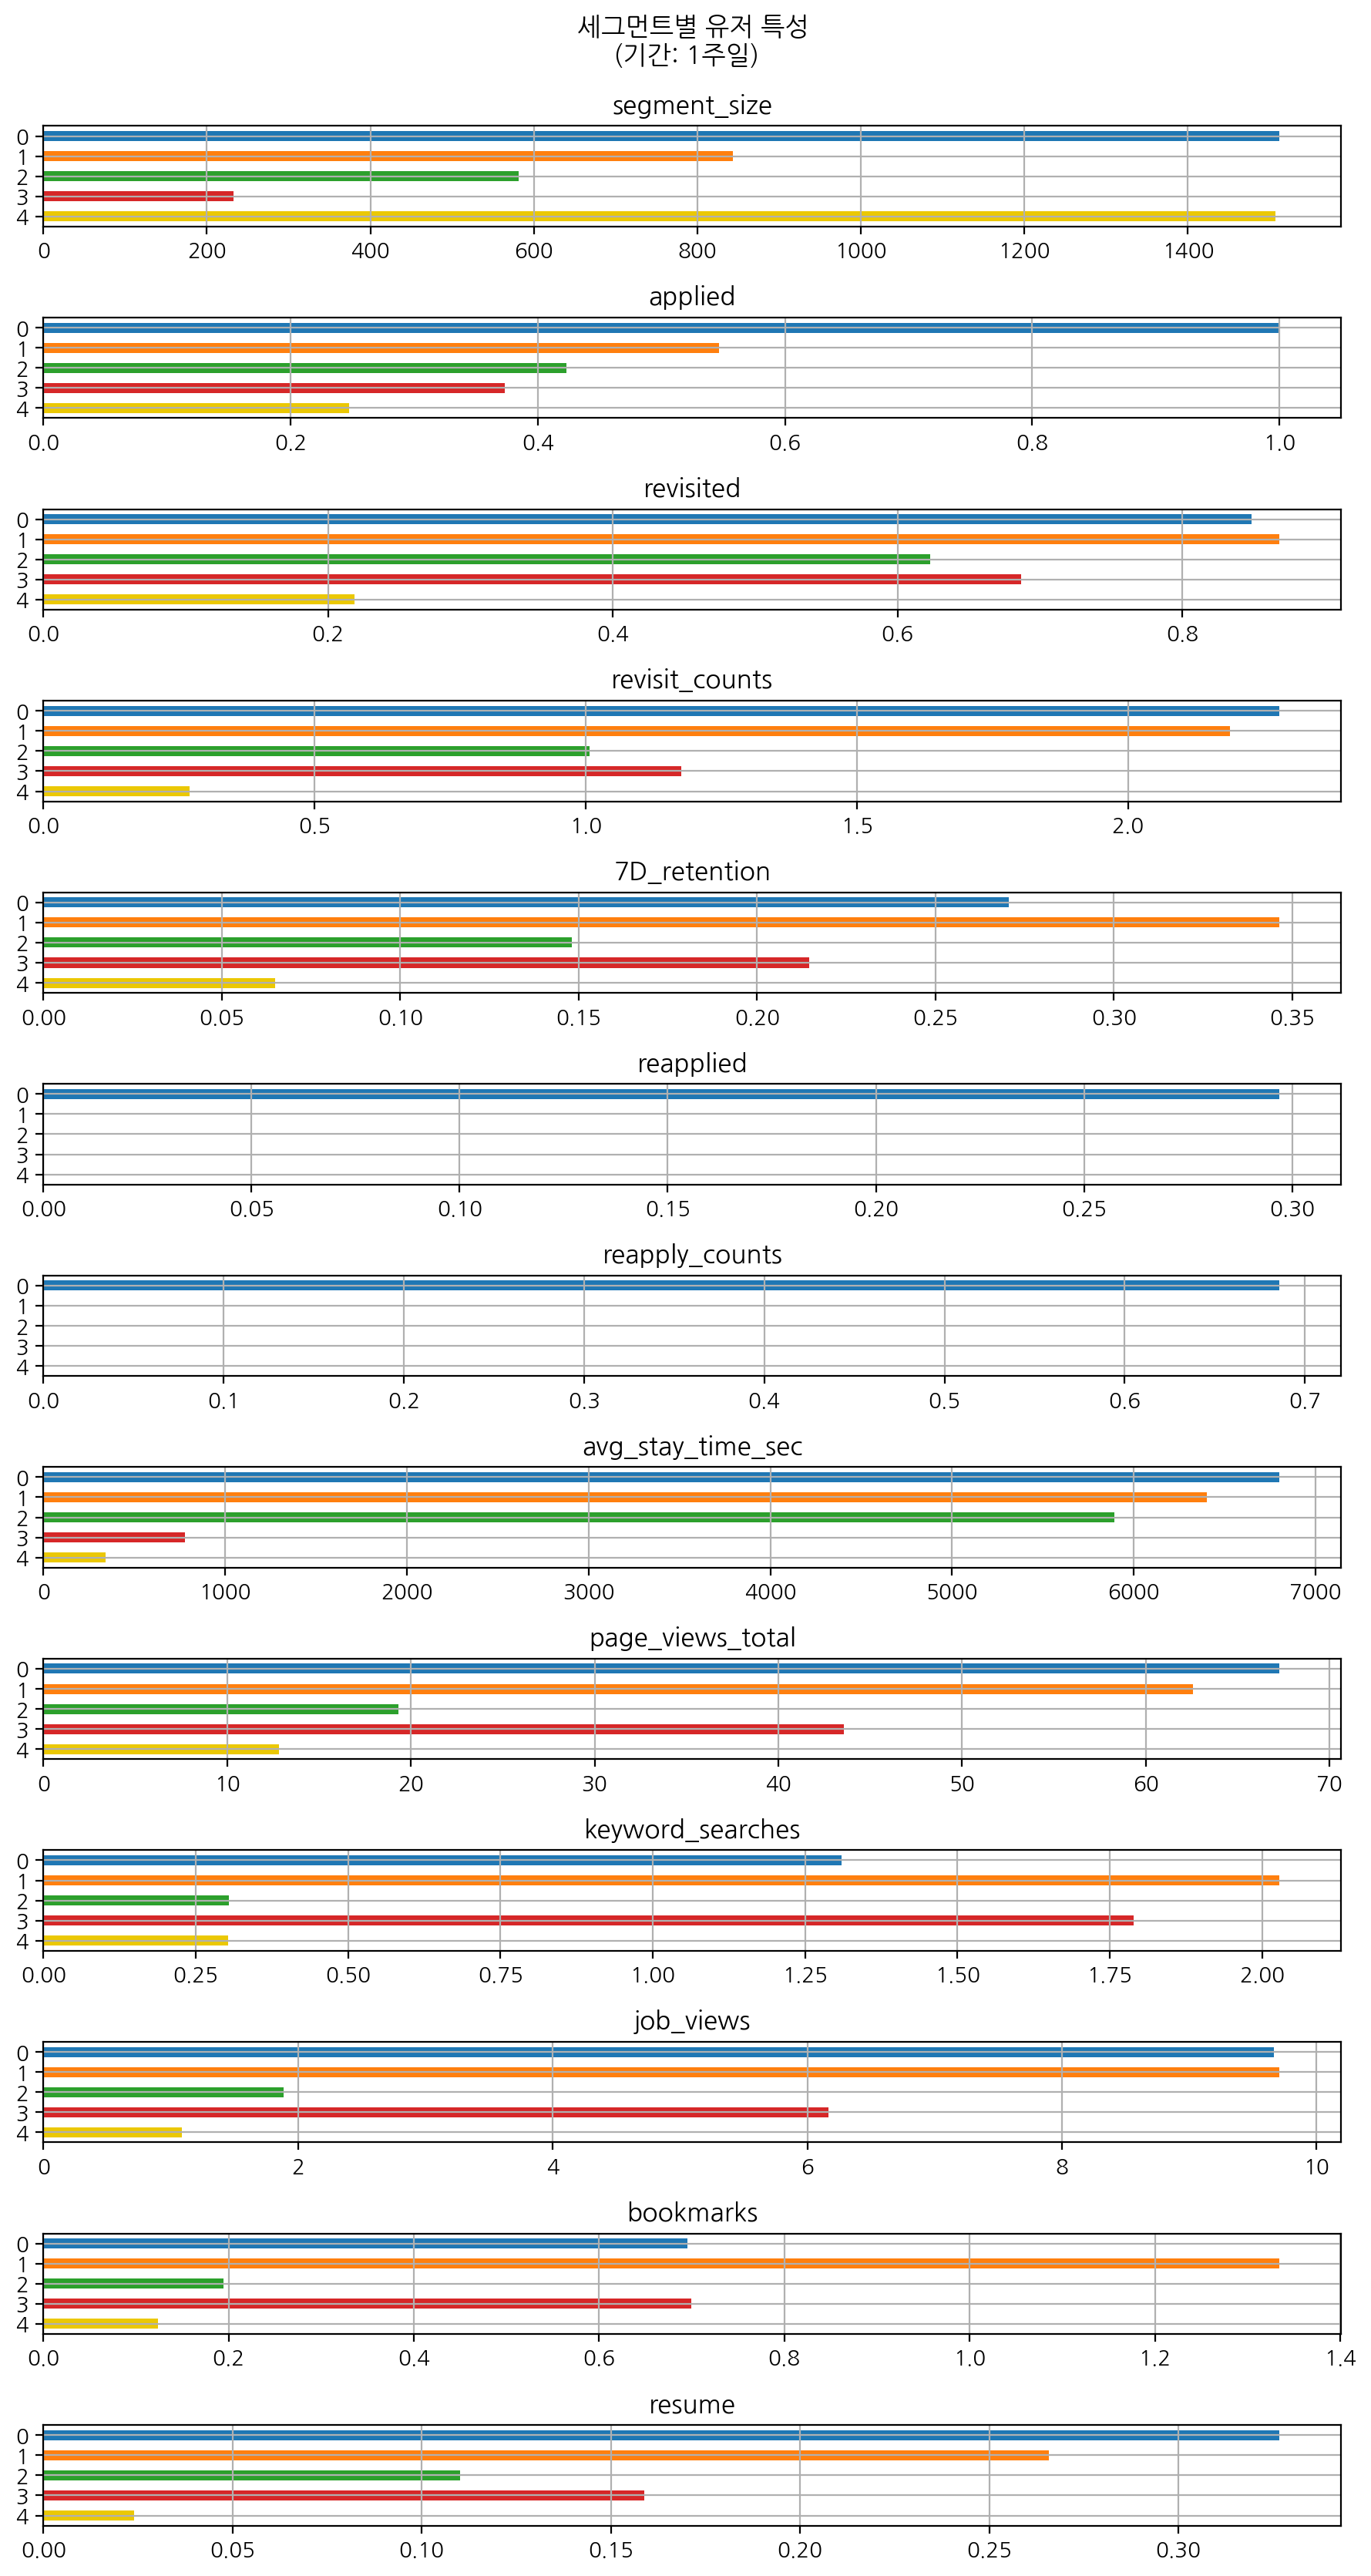

In [67]:
palette = [
     '#ebc804',
     '#d62728',
     '#2ca02c',
     '#ff7f0e',
     "#1f77b4",
]

fig, ax = plt.subplots(13, 1, figsize=(9, 17))
axes = ax.flatten()
for i, col in enumerate(user_stats_wk_sum.columns.drop('seg')):
    user_stats_wk_sum[col].T.iloc[::-1].plot(kind='barh', color=palette, ax=axes[i])
    axes[i].set_title(f"{col}")
    axes[i].grid(True)

plt.suptitle('  세그먼트별 유저 특성\n(기간: 1주일)\n')
plt.tight_layout()
plt.show()

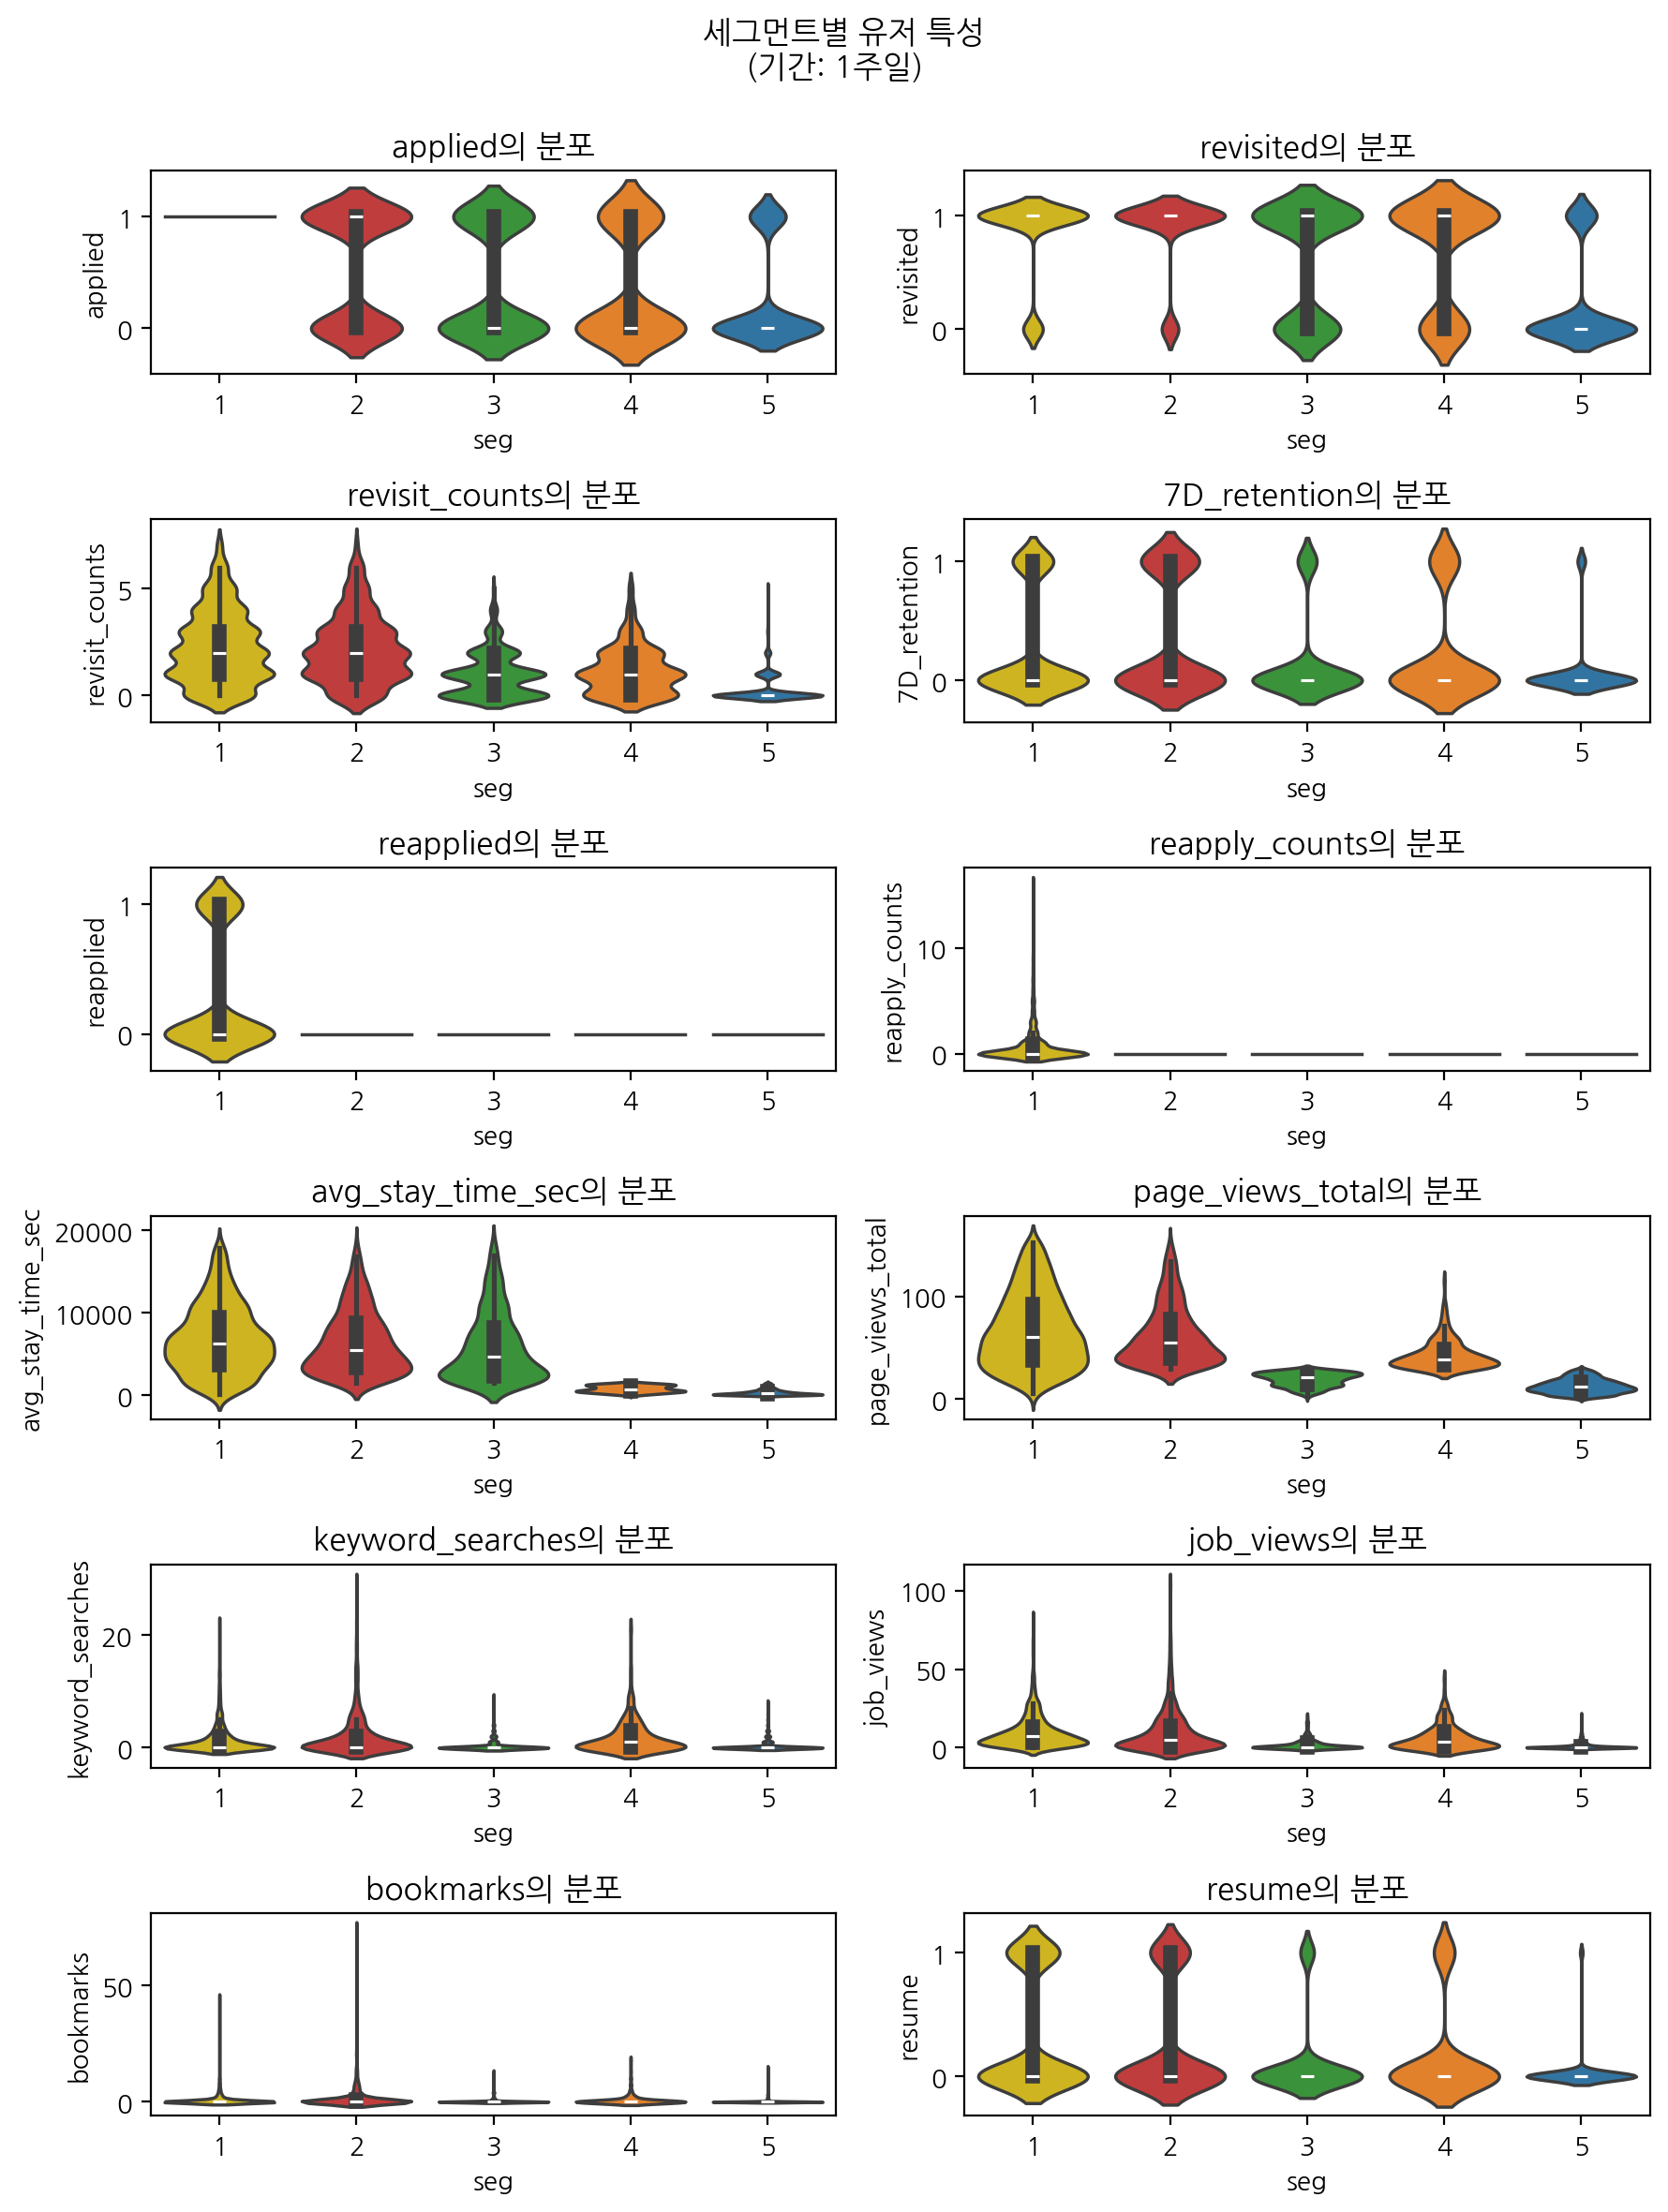

In [68]:
fig, ax = plt.subplots(6, 2, figsize=(9, 12))
axes = ax.flatten()

for i, feature in enumerate(user_stats_wk_sum.columns.drop(['seg', 'segment_size'])):
    sns.violinplot(data=user_stats_wk_concat, x='seg', y=feature, 
                palette=palette, ax=axes[i])
    axes[i].set_title(f"{feature}의 분포")

plt.suptitle('  세그먼트별 유저 특성\n(기간: 1주일)\n')
plt.tight_layout()
plt.show()

## 세그먼트 분석 (범위: 가입 후 한달 활동)

### 지표 분포 비교

In [69]:
# 평균 체류 시간
# 세션별 시작, 종료 시간
session_times_m = log_firstmonth.groupby(['user_uuid', 'session_id'])['timestamp_parsed'].agg(
    session_start='min',
    session_end='max'
).reset_index()

# 세션별 체류 시간(초)
session_times_m['session_duration_sec'] = (session_times_m['session_end'] - session_times_m['session_start']).dt.total_seconds()

# 세션 체류 시간 상한 적용(상한선 6시간)
session_times_m['session_duration_sec'] = session_times_m['session_duration_sec'].clip(upper=21600)

# 유저별 평균 체류 시간(초)
avg_stay_time_m = session_times_m.groupby(by='user_uuid')['session_duration_sec'].mean().reset_index(name='avg_stay_time_sec')

# 유의미한 세그먼트 기준 탐색 목적이므로, 평균적 경향 확인 필요 -> IQR 기준 이상치 제거
avg_stay_time_m = remove_outliers_iqr(avg_stay_time_m, 'avg_stay_time_sec')  

lower_fence: -8505.067589742532, lower than lower_fence: 0
upper_fence: 21952.613218179977, higher than upper_fence: 0


In [70]:
# 총 페이지 뷰 수
page_views_m = log_firstmonth[(log_firstmonth['method']=='GET') & (~log_firstmonth['URL'].str.startswith('api/'))]
page_views_m = page_views_m.groupby(by='user_uuid').size().reset_index(name='page_views_total')
page_views_m = remove_outliers_iqr(page_views_m, 'page_views_total')  # IQR 기준 이상치 제거

lower_fence: -162.5, lower than lower_fence: 0
upper_fence: 345.5, higher than upper_fence: 385


In [71]:
# 개인 이력서 저장 여부
mask_resume = (log_firstmonth['URL']=='api/users/id/resume/step2') & (log_firstmonth['method']=='POST')
resume_users_m = log_firstmonth[mask_resume]['user_uuid'].unique()
log_firstmonth.loc[:, 'resume'] = log_firstmonth['user_uuid'].isin(resume_users_m)

In [72]:
# 목표 변수: 1달 내 지원 여부(가입 후 일주일 데이터를 통한 1 - 2주차 타겟팅 전략의 목표로 삼기 적합)
log_firstmonth.loc[:, 'applied_within_month'] = log_firstmonth['user_uuid'].isin(users_applied_month)

In [73]:
# 유저 요약 테이블 생성
user_stats_m = log_firstmonth.groupby('user_uuid').agg(
    num_visit_days=('date', 'nunique'),                 # 방문 일수
    keyword_searches=('searched_keyword', 'sum'),       # 키워드 검색 횟수
    job_views=('viewed_job', 'sum'),                    # 채용 공고 열람 횟수
    bookmarks=('bookmarked', 'sum'),                    # 북마크 횟수
    resume=('resume', 'max'),                           # 사전 이력서 작성 여부
    applied=('applied_within_month', 'max'),            # KPI(1달 내 지원 여부)
    total_app=('applied', 'sum')                        # 총 지원 횟수
).reset_index()

user_stats_m['resume'] = user_stats_m['resume'].astype(int)
user_stats_m['applied'] = user_stats_m['applied'].astype(int)

# 평균 체류 시간, 페이지뷰
user_stats_m = pd.merge(user_stats_m, avg_stay_time_m, on='user_uuid', how='inner')
user_stats_m = pd.merge(user_stats_m, page_views_m, on='user_uuid', how='inner')

# 재방문 일수
user_stats_m['num_visit_days'] = user_stats_m['num_visit_days'] - 1
user_stats_m.rename(columns={'num_visit_days': 'revisit_counts'}, inplace=True)

# 재방문 여부
user_stats_m['revisited'] = user_stats_m['revisit_counts'] > 0

# 재지원 횟수
user_stats_m['total_app'] = np.where(user_stats_m['total_app'] > 0, user_stats_m['total_app'] - 1, user_stats_m['total_app'])
user_stats_m.rename(columns={'total_app': 'reapply_counts'}, inplace=True)

# 재지원 여부
user_stats_m['reapplied'] = user_stats_m['reapply_counts'] > 0

# 7D 리텐션
user_stats_m['7D_retention'] = 0
user_stats_m.loc[user_stats_m['user_uuid'].isin(ret_users), '7D_retention'] = 1

In [74]:
# 컬럼 순서 지정
user_stats_m = user_stats_m[['user_uuid', 
                                'applied',            # KPI
                                'revisited',          # 관여도 지표
                                'revisit_counts',     
                                '7D_retention',       
                                'reapplied',         
                                'reapply_counts',     
                                'avg_stay_time_sec',  # 세그먼트 기준
                                'page_views_total',
                                'keyword_searches',   # 행동 지표
                                'job_views', 
                                'bookmarks', 
                                'resume']]

In [75]:
# 전체 유저
user_stats_m.describe()

,applied,revisit_counts,7D_retention,reapply_counts,avg_stay_time_sec,page_views_total,keyword_searches,job_views,bookmarks,resume
count,4805.000000,4805.000000,4805.000000,4805.000000,4805.000000,4805.000000,4805.000000,4805.000000,4805.000000,4805.000000
mean,0.575650,4.873257,0.201249,0.922164,6984.676406,88.658689,2.253070,14.401249,1.204579,0.281374
std,0.494295,4.924023,0.400975,2.334572,5183.163131,81.273305,4.647308,20.621759,3.779847,0.449716
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,2338.354189,26.000000,0.000000,1.000000,0.000000,0.000000
50%,1.000000,3.000000,0.000000,0.000000,6809.688794,60.000000,0.000000,7.000000,0.000000,0.000000
75%,1.000000,8.000000,0.000000,1.000000,10502.192284,130.000000,3.000000,19.000000,1.000000,1.000000
max,1.000000,29.000000,1.000000,30.000000,21600.000000,345.000000,90.000000,205.000000,91.000000,1.000000


In [76]:
# 일주일 내 전환 세그먼트
app_m = user_stats_m[user_stats_m['user_uuid'].isin(app_wk_users)]
app_m.describe()

,applied,revisit_counts,7D_retention,reapply_counts,avg_stay_time_sec,page_views_total,keyword_searches,job_views,bookmarks,resume
count,1484.0,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000
mean,1.0,5.039084,0.264151,1.226415,8231.879571,91.736523,1.919137,14.022911,0.874663,0.345687
std,0.0,4.734469,0.441029,2.702353,4183.483033,64.375940,3.604550,16.481527,2.841353,0.475752
min,1.0,0.000000,0.000000,0.000000,142.142562,6.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,1.000000,0.000000,0.000000,5376.936753,42.750000,0.000000,3.000000,0.000000,0.000000
50%,1.0,4.000000,0.000000,0.000000,7943.443545,76.000000,0.000000,8.000000,0.000000,0.000000
75%,1.0,7.000000,1.000000,1.000000,11016.075461,126.250000,2.000000,19.000000,0.000000,1.000000
max,1.0,27.000000,1.000000,30.000000,21600.000000,345.000000,59.000000,159.000000,45.000000,1.000000


In [77]:
# 일주일 내 미전환 전체
napp_m = user_stats_m[~user_stats_m['user_uuid'].isin(app_wk_users)]
napp_m.describe()

,applied,revisit_counts,7D_retention,reapply_counts,avg_stay_time_sec,page_views_total,keyword_searches,job_views,bookmarks,resume
count,3321.000000,3321.000000,3321.000000,3321.000000,3321.000000,3321.000000,3321.000000,3321.000000,3321.000000,3321.000000
mean,0.386028,4.799157,0.173141,0.786209,6427.359484,87.283348,2.402288,14.570310,1.352002,0.252635
std,0.486911,5.005330,0.378426,2.136474,5481.778700,87.752772,5.037407,22.224104,4.122722,0.434589
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,956.245781,19.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,3.000000,0.000000,0.000000,6051.919871,50.000000,0.000000,5.000000,0.000000,0.000000
75%,1.000000,8.000000,0.000000,0.000000,10035.456157,133.000000,3.000000,19.000000,1.000000,1.000000
max,1.000000,29.000000,1.000000,28.000000,21600.000000,345.000000,90.000000,205.000000,91.000000,1.000000


In [78]:
# 일주일 내 미전환, 평균 체류 시간 >= 1500초, 총 페이지뷰 >= 30 세그먼트
seg_a_m = user_stats_m[user_stats_m['user_uuid'].isin(seg_a_users)]
seg_a_m.describe()

,applied,revisit_counts,7D_retention,reapply_counts,avg_stay_time_sec,page_views_total,keyword_searches,job_views,bookmarks,resume
count,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000
mean,0.500000,7.719415,0.319149,0.787234,8236.265129,135.071809,4.059840,24.049202,2.393617,0.390957
std,0.500333,5.525850,0.466457,1.750768,3722.982632,81.859173,6.524797,26.419165,4.921689,0.488290
min,0.000000,0.000000,0.000000,0.000000,1082.511323,30.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.000000,0.000000,0.000000,5574.316941,64.000000,0.000000,5.000000,0.000000,0.000000
50%,0.500000,7.000000,0.000000,0.000000,7864.262394,118.000000,2.000000,15.000000,0.000000,0.000000
75%,1.000000,11.000000,1.000000,1.000000,10790.768011,190.000000,5.000000,34.000000,3.000000,1.000000
max,1.000000,29.000000,1.000000,14.000000,21600.000000,344.000000,68.000000,167.000000,33.000000,1.000000


In [79]:
# 일주일 내 미전환, 평균 체류 시간 >= 1500초, 총 페이지뷰 < 30 세그먼트
seg_b_m = user_stats_m[user_stats_m['user_uuid'].isin(seg_b_users)]
seg_b_m.describe()

,applied,revisit_counts,7D_retention,reapply_counts,avg_stay_time_sec,page_views_total,keyword_searches,job_views,bookmarks,resume
count,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000
mean,0.408127,4.766784,0.143110,0.761484,8011.378265,70.879859,1.519435,10.832155,1.014134,0.226148
std,0.491922,4.301721,0.350494,1.812835,4359.081281,71.867477,3.142426,17.750835,2.994357,0.418706
min,0.000000,0.000000,0.000000,0.000000,819.645434,2.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,4529.096857,23.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,4.000000,0.000000,0.000000,7458.290490,39.000000,0.000000,4.000000,0.000000,0.000000
75%,1.000000,7.000000,0.000000,1.000000,10953.098872,100.000000,2.000000,12.000000,0.000000,0.000000
max,1.000000,21.000000,1.000000,19.000000,21600.000000,345.000000,35.000000,118.000000,30.000000,1.000000


In [80]:
# 일주일 내 미전환, 평균 체류 시간 < 1500초, 총 페이지뷰 >= 30 세그먼트
seg_c_m = user_stats_m[user_stats_m['user_uuid'].isin(seg_c_users)]
seg_c_m.describe()

,applied,revisit_counts,7D_retention,reapply_counts,avg_stay_time_sec,page_views_total,keyword_searches,job_views,bookmarks,resume
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,0.327103,5.556075,0.191589,0.542056,5147.563410,105.822430,3.350467,19.294393,1.925234,0.266355
std,0.470255,4.973558,0.394474,1.382523,4966.007055,79.517006,5.023286,23.479134,4.583500,0.443089
min,0.000000,0.000000,0.000000,0.000000,119.386219,30.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,739.623677,41.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,4.000000,0.000000,0.000000,3636.072852,78.500000,2.000000,10.000000,0.000000,0.000000
75%,1.000000,9.000000,0.000000,0.000000,8312.292973,140.750000,4.750000,28.000000,1.000000,1.000000
max,1.000000,22.000000,1.000000,9.000000,21600.000000,345.000000,37.000000,117.000000,29.000000,1.000000


In [81]:
# 일주일 내 미전환, 평균 체류 시간 < 1500초, 총 페이지뷰 < 30 세그먼트
seg_d_m = user_stats_m[user_stats_m['user_uuid'].isin(seg_d_users)]
seg_d_m.describe()

,applied,revisit_counts,7D_retention,reapply_counts,avg_stay_time_sec,page_views_total,keyword_searches,job_views,bookmarks,resume
count,1475.000000,1475.000000,1475.000000,1475.000000,1475.000000,1475.000000,1475.000000,1475.000000,1475.000000,1475.000000
mean,0.231864,2.627119,0.063051,0.405424,3892.608587,45.365424,1.107797,6.846102,0.646102,0.142373
std,0.422166,3.598857,0.243137,1.398186,5252.131276,59.882200,2.708580,13.577259,2.787993,0.349551
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,155.937039,11.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,784.551829,20.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,4.000000,0.000000,0.000000,6626.749505,52.500000,1.000000,8.000000,0.000000,0.000000
max,1.000000,22.000000,1.000000,14.000000,21600.000000,337.000000,26.000000,132.000000,63.000000,1.000000


In [82]:
app_m['reapplied'].mean()

0.3665768194070081

In [83]:
# 세그먼트 라벨링
app_m['seg'] = '1'
seg_a_m['seg'] = '2'
seg_b_m['seg'] = '3'
seg_c_m['seg'] = '4'
seg_d_m['seg'] = '5'

# 세그먼트 크기
app_m['segment_size'] = len(app_m)
seg_a_m['segment_size'] = len(seg_a_m)
seg_b_m['segment_size'] = len(seg_b_m)
seg_c_m['segment_size'] = len(seg_c_m)
seg_d_m['segment_size'] = len(seg_d_m)

# 합치기
user_stats_m_concat = pd.concat([app_m, seg_a_m, seg_b_m, seg_c_m, seg_d_m])
user_stats_m_sum = user_stats_m_concat.drop(columns='user_uuid').groupby(by='seg', as_index=False).mean()

# 전체 평균값 행 만들기
overall_mean = user_stats_m.drop(columns='user_uuid').mean()
overall_mean['seg'] = '0'
overall_mean['segment_size'] = user_stats_m_sum['segment_size'].mean()  # 세그먼트 크기 평균

# 세그먼트 평균이랑 전체 평균 concat
user_stats_m_sum = pd.concat([
    pd.DataFrame([overall_mean]),
    user_stats_m_sum
], ignore_index=True)

# 컬럼 순서 재지정
user_stats_m_sum = user_stats_m_sum[['segment_size', 'seg', 'applied', 'revisited', 'revisit_counts', '7D_retention',
       'reapplied', 'reapply_counts', 'avg_stay_time_sec', 'page_views_total', 'keyword_searches', 'job_views', 
       'bookmarks', 'resume']]

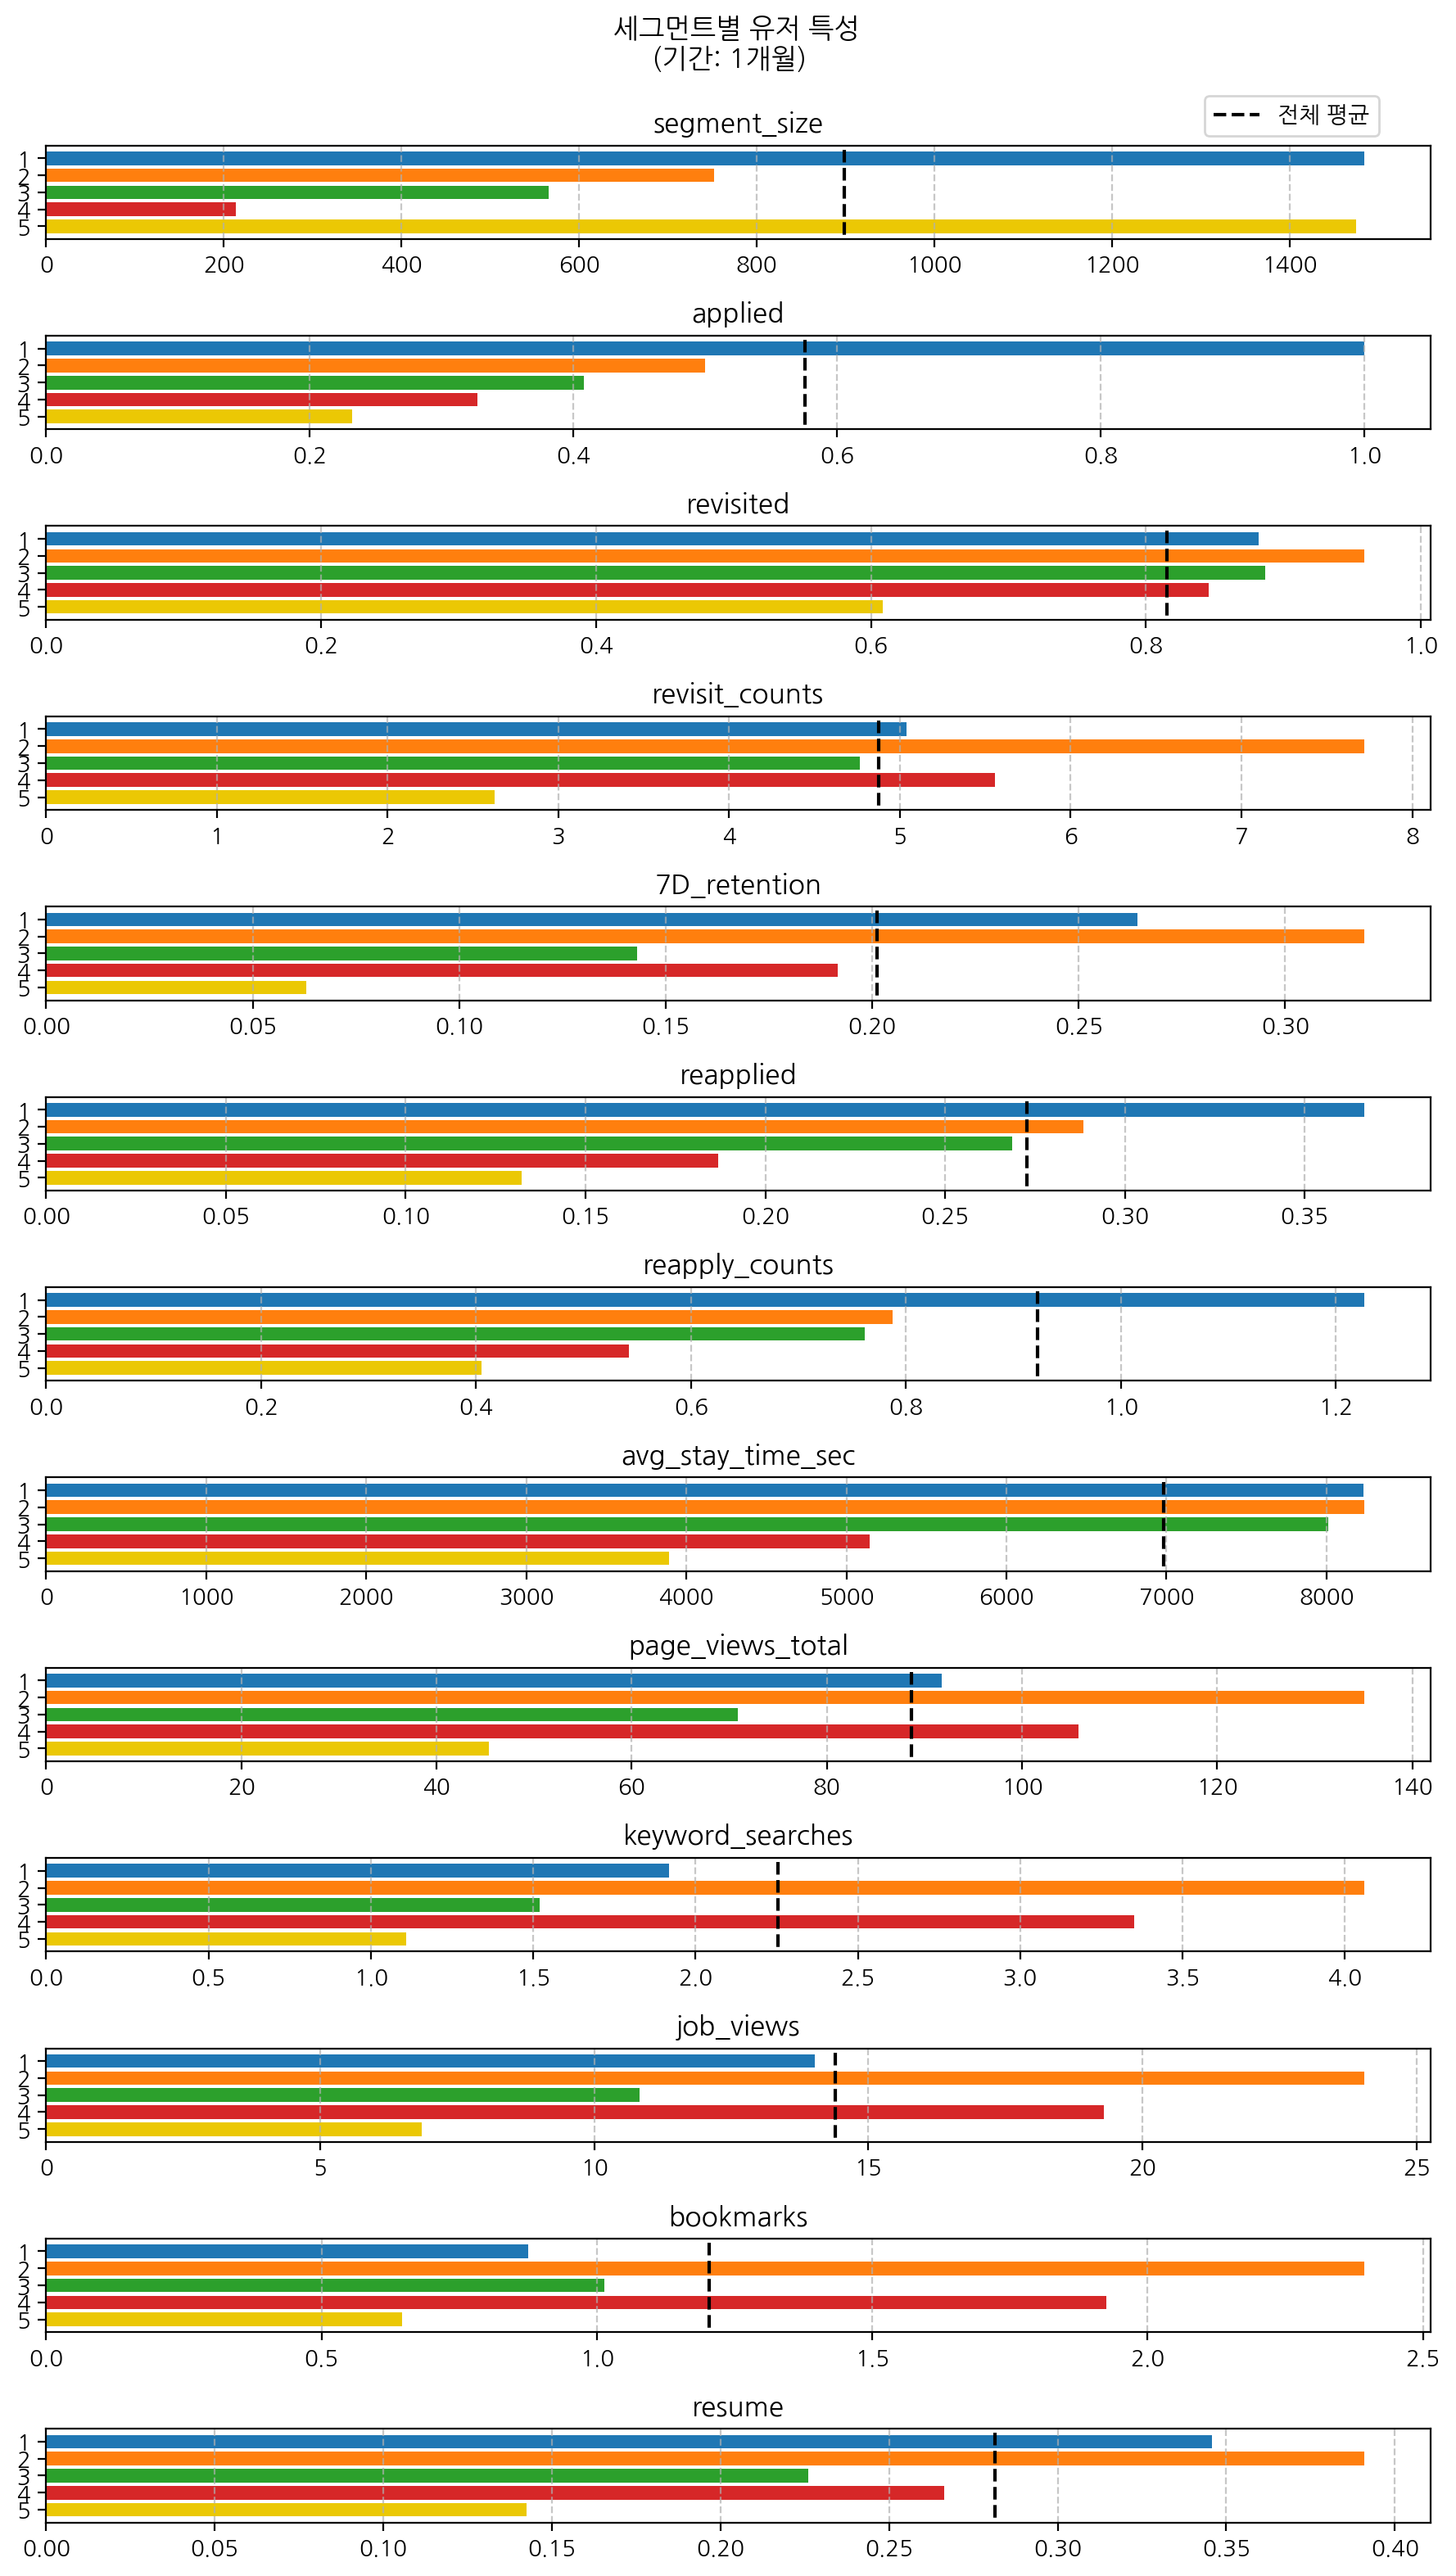

In [84]:
# 세그먼트 레이블
seg_labels = user_stats_m_sum['seg'].tolist()

# 실제로 막대를 그릴 세그먼트만 따로 필터링
non_mean_indices = [i for i, seg in enumerate(seg_labels) if seg != '0']
mean_index = seg_labels.index('0')  # 세그먼트 0 위치 (단일)

# 고정 색상 (원하면 dict로 따로 구성해도 됨)
palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', "#ebc804"]

fig, ax = plt.subplots(len(user_stats_m_sum.columns.drop('seg')), 1, figsize=(9, 16))
axes = ax.flatten()

for i, col in enumerate(user_stats_m_sum.columns.drop('seg')):
    values = user_stats_m_sum[col].values

    # 세그먼트 평균 (0번 세그먼트 값)
    mean_val = values[mean_index]

    # 개별 막대 그리기 (세그먼트 1~5만, y=0~4)
    for draw_idx, (bar_idx, palette_idx) in enumerate(zip(non_mean_indices, range(len(palette)))):
        val = values[bar_idx]
        axes[i].barh(draw_idx, val, color=palette[palette_idx])

    # 평균선: y=0~4 기준으로 맞추기
    axes[i].vlines(x=mean_val, ymin=-0.5, ymax=4.5,
                linestyles='dashed', color='black',
                label='전체 평균' if i == 0 else "")

    # y축 설정
    axes[i].set_yticks([0,1,2,3,4])
    axes[i].set_yticklabels([1,2,3,4,5])
    axes[i].invert_yaxis()
    
    axes[i].set_title(f"{col}")
    axes[i].grid(axis='x', linestyle='--', alpha=0.7)


axes[0].legend(loc='upper center', bbox_to_anchor=(0.9, 1.65), ncol=1)
plt.suptitle('  세그먼트별 유저 특성\n(기간: 1개월)')
plt.tight_layout()
plt.show()

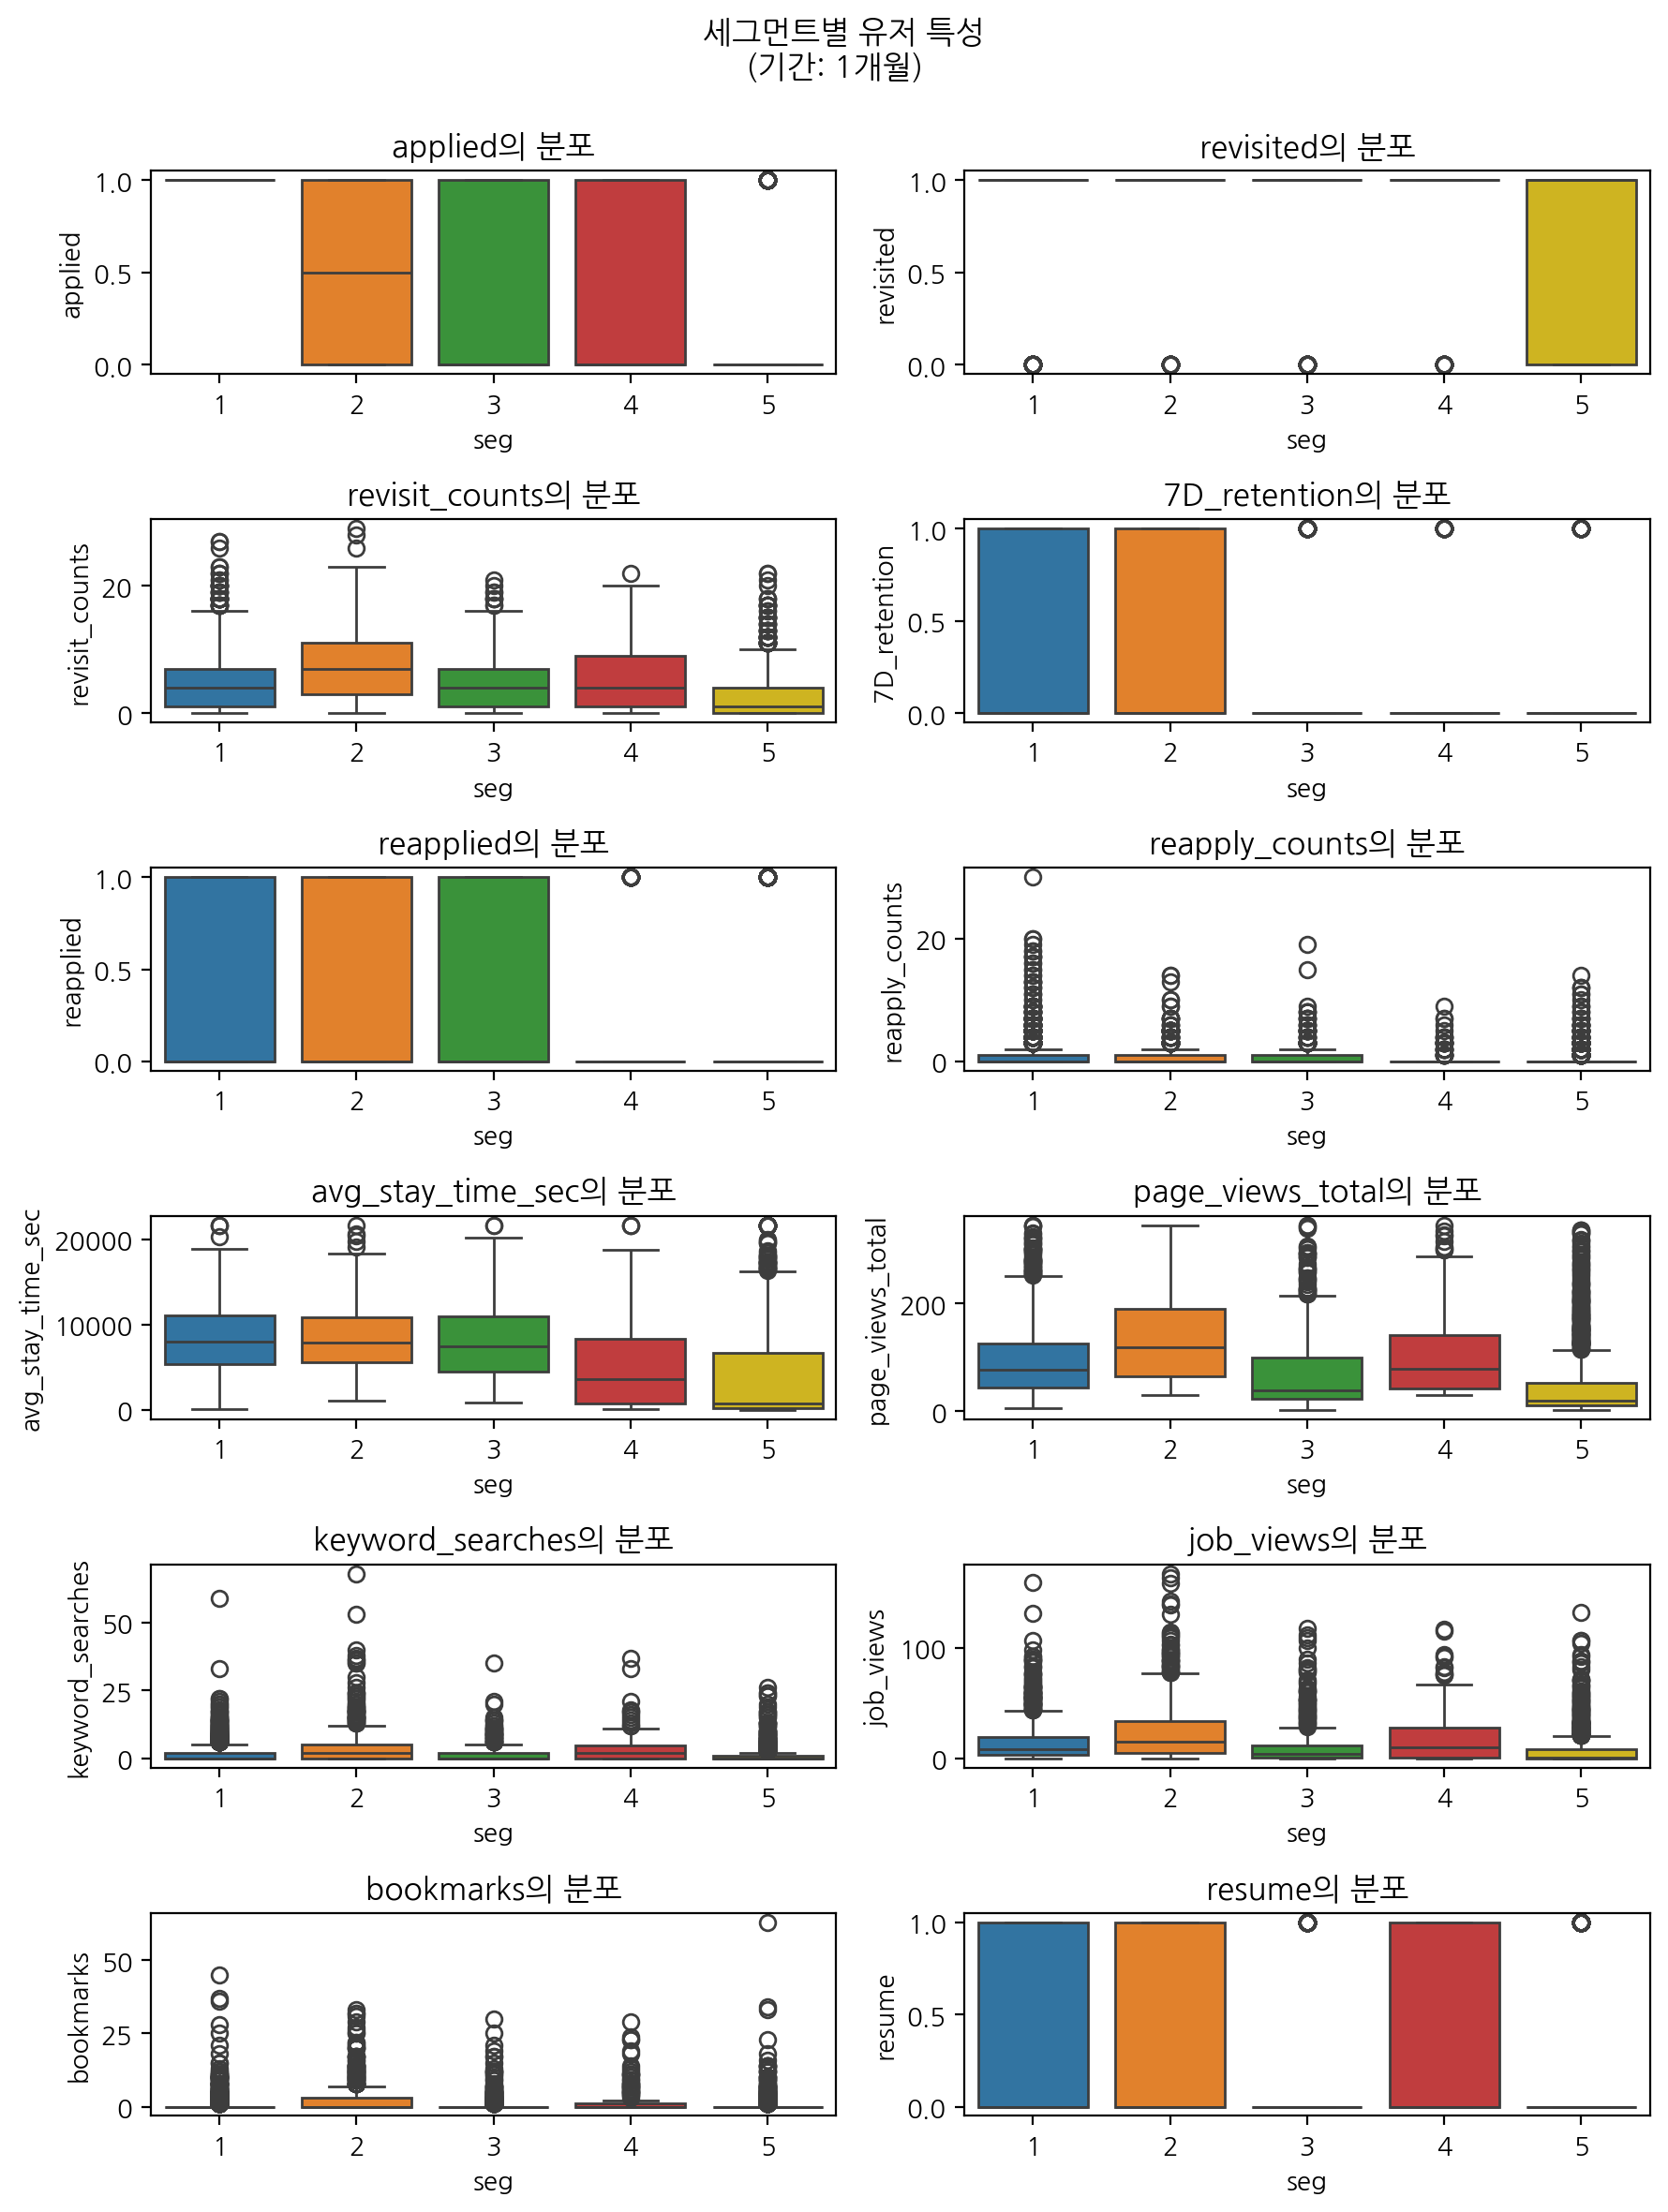

In [86]:
palette = [
     '#1f77b4',
     '#ff7f0e',
     '#2ca02c',
     '#d62728',
     "#ebc804",
]

fig, ax = plt.subplots(6, 2, figsize=(9, 12))
axes = ax.flatten()

for i, feature in enumerate(user_stats_m_sum.columns.drop(['seg', 'segment_size'])):
    sns.boxplot(data=user_stats_m_concat.drop(columns='user_uuid'), x='seg', y=feature, 
                palette=palette, ax=axes[i])
    axes[i].set_title(f"{feature}의 분포")

plt.suptitle('  세그먼트별 유저 특성\n(기간: 1개월)\n')
plt.tight_layout()
plt.show()

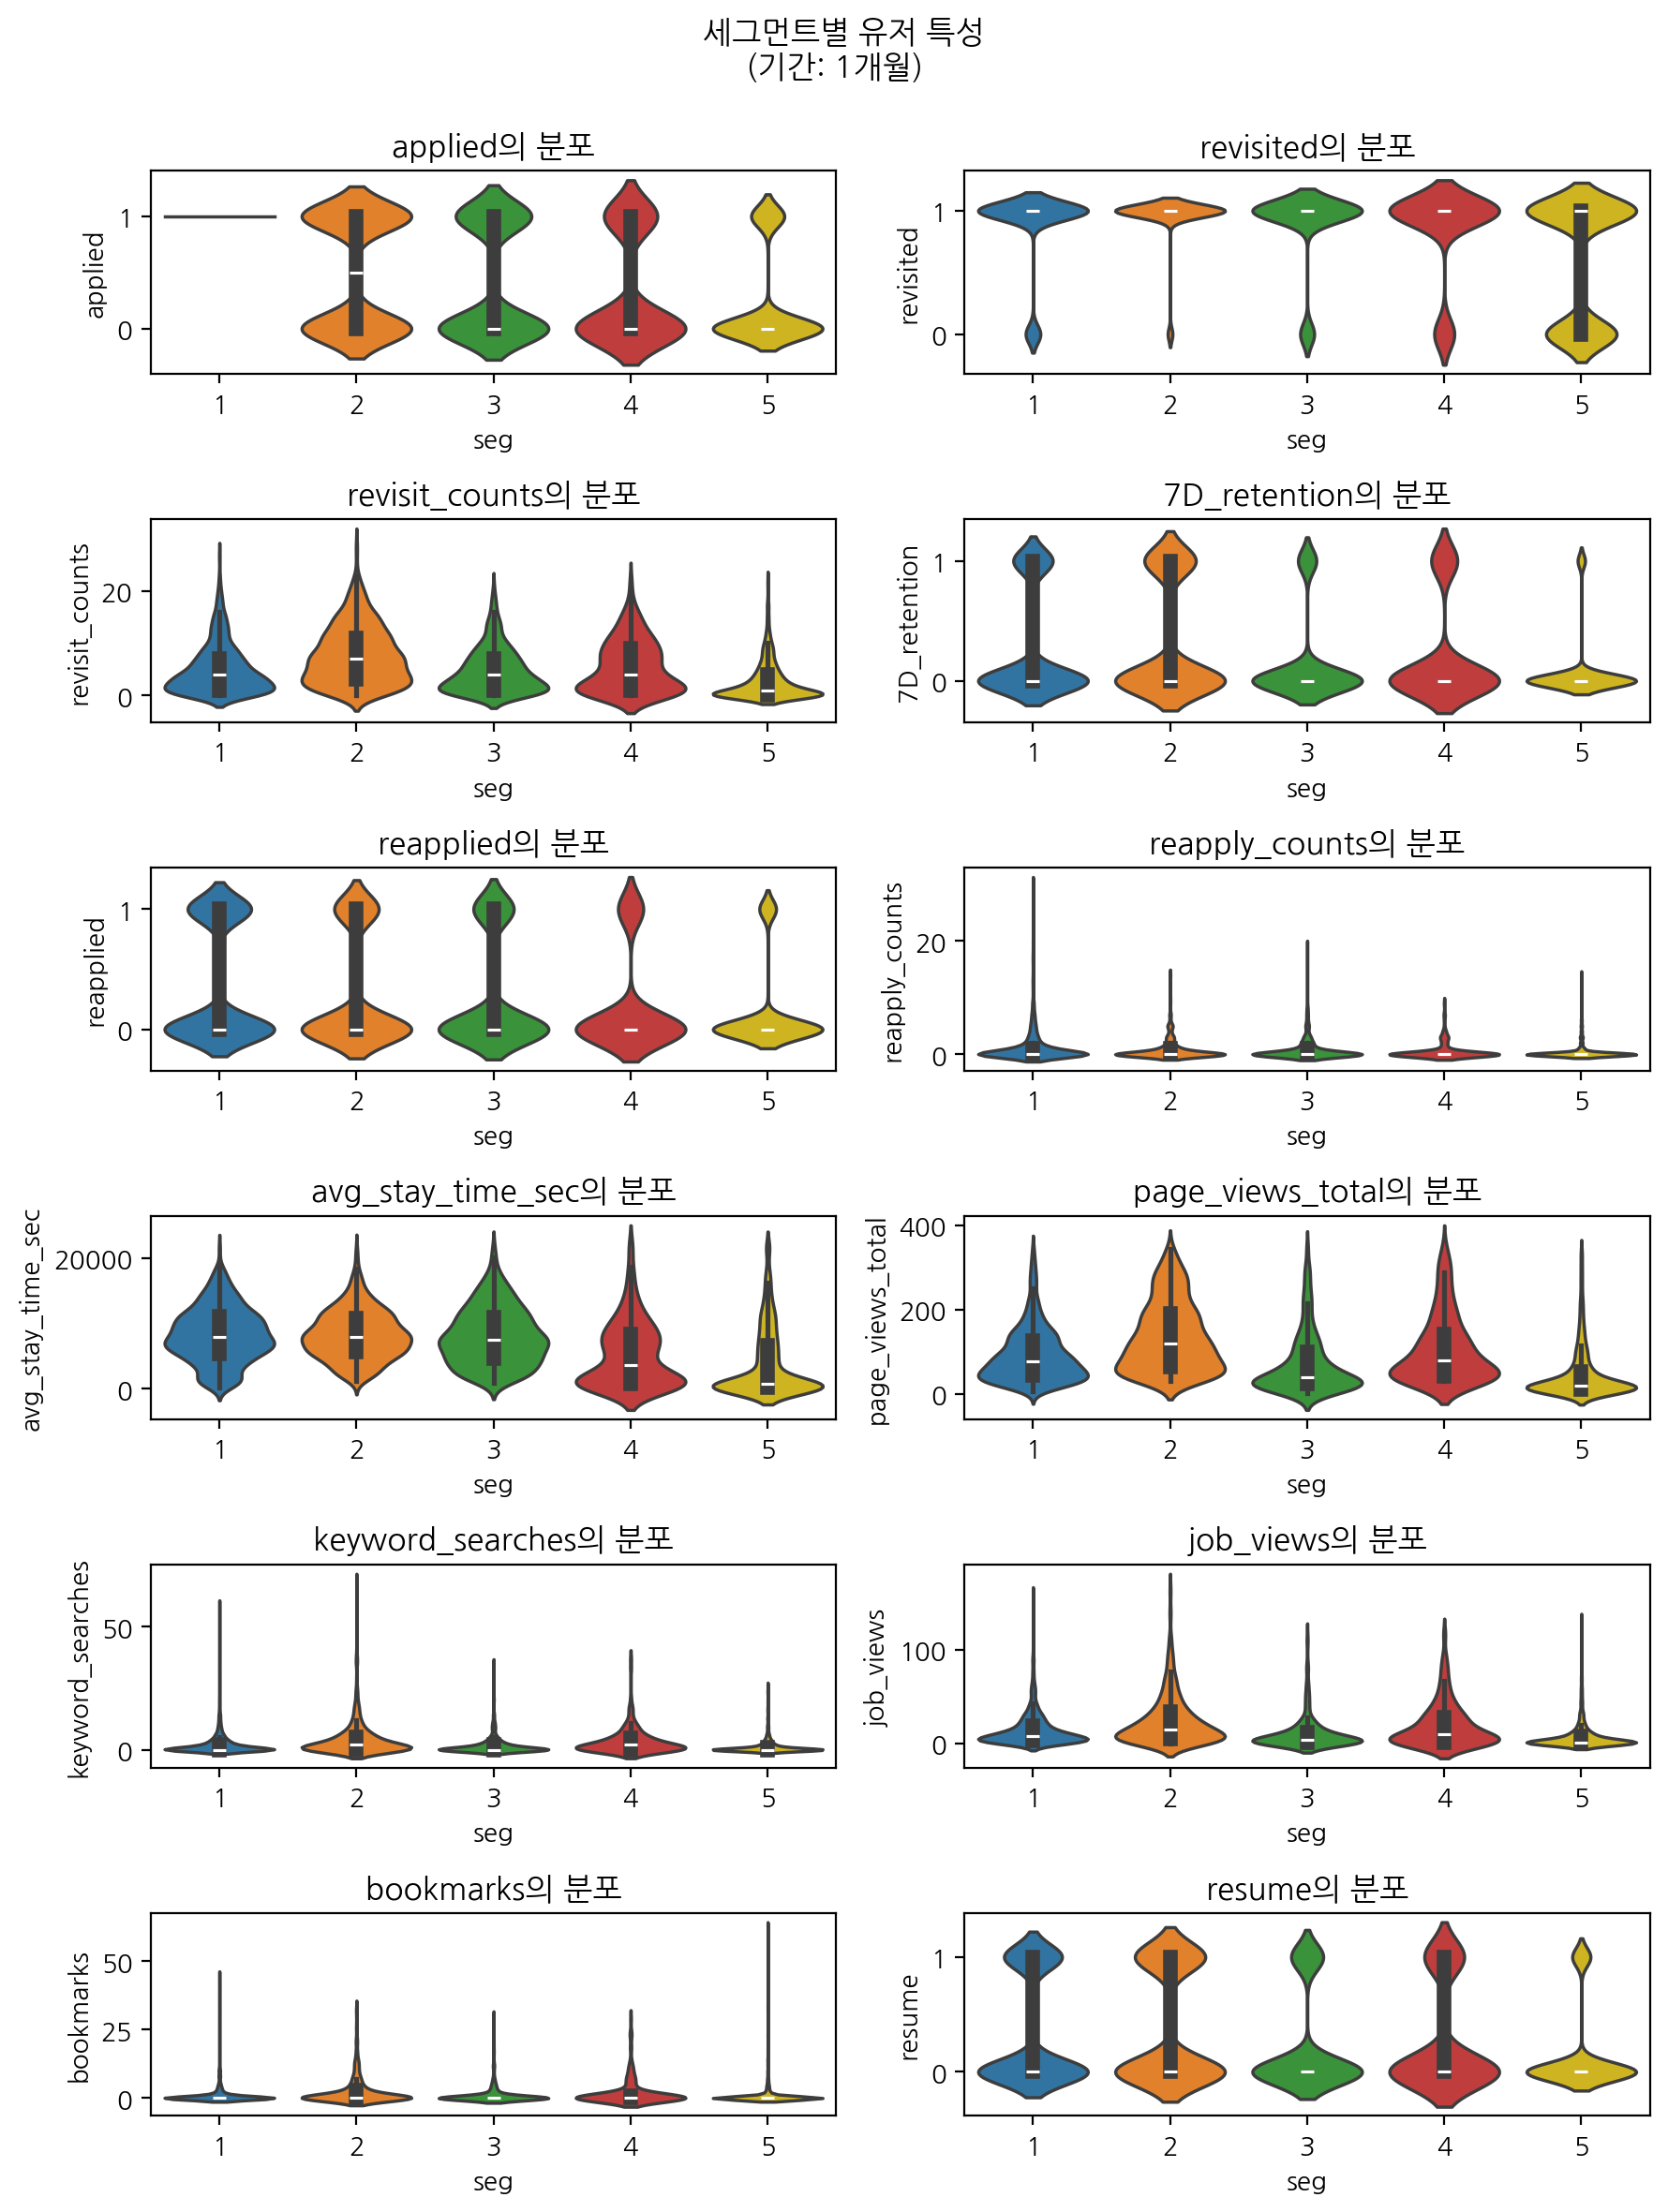

In [87]:
fig, ax = plt.subplots(6, 2, figsize=(9, 12))
axes = ax.flatten()

for i, feature in enumerate(user_stats_m_sum.columns.drop(['seg', 'segment_size'])):
    sns.violinplot(data=user_stats_m_concat.drop(columns='user_uuid'), x='seg', y=feature, 
                palette=palette, ax=axes[i])
    axes[i].set_title(f"{feature}의 분포")

plt.suptitle('  세그먼트별 유저 특성\n(기간: 1개월)\n')
plt.tight_layout()
plt.show()

### 전환률 차이 검정

In [ ]:
# 1. 카이 제곱 검정(전체적으로 차이가 있는지 확인)

# 데이터 준비
data = user_stats_m_concat.groupby(by='seg').agg(
            applied = ('applied', 'sum'),
            count = ('applied', 'count')
        )
data.loc[:, 'not_applied'] = data['count'] - data['applied']
data = data.drop(columns='count')

# 카이 제곱 검정
chi2, p, dof, expected = chi2_contingency(data)
expected_table = pd.DataFrame(expected, index=data.index, columns=data.columns)

print(f"Chi-square 통계량: {chi2:.4f}")
print(f"p-value: {p}")
print(f"자유도: {dof}")
print("\n기대빈도표:")
print(expected_table)

# 귀무가설 기각됨 (p <0.001)

Chi-square 통계량: 1919.0677
p-value: 0.0
자유도: 4

기대빈도표:
        applied  not_applied
seg                         
1    827.087954   656.912046
2    419.117346   332.882654
3    315.452683   250.547317
4    119.270096    94.729904
5    822.071922   652.928078


In [ ]:
# 2. pairwise test(각 세그먼트별로 차이가 있는지 확인)

# 데이터 준비
successes = data['applied'].values
totals = data.sum(axis=1).values

# 가능한 모든 쌍 생성
comparisons = list(itertools.combinations(range(len(data)), 2))
n_tests = len(comparisons)

# Bonferroni 보정된 유의수준
alpha = 0.05
adjusted_alpha = alpha / n_tests

# pairwise test
for i, j in comparisons:
    count = [successes[i], successes[j]]
    nobs = [totals[i], totals[j]]

    stat, pval = proportions_ztest(count, nobs)
    result = '유의미함' if pval < adjusted_alpha else '유의미하지 않음'

    print(f"{data.index[i]} vs {data.index[j]}")
    print(f"Z 통계량: {stat:.4f}")
    print(f"p-value: {pval:.4f}")
    print(f"result: {result}")
    print("============================")
    
# (세그먼트 3 & 세그먼트 4)를 제외한 모든 쌍에서 유의미한 차이가 나타남

1 vs 2
Z 통계량: 29.8663
p-value: 0.0000
result: 유의미함
1 vs 3
Z 통계량: 32.4023
p-value: 0.0000
result: 유의미함
1 vs 4
Z 통계량: 33.0320
p-value: 0.0000
result: 유의미함
1 vs 5
Z 통계량: 42.9792
p-value: 0.0000
result: 유의미함
2 vs 3
Z 통계량: 3.3123
p-value: 0.0009
result: 유의미함
2 vs 4
Z 통계량: 4.4763
p-value: 0.0000
result: 유의미함
2 vs 5
Z 통계량: 12.8030
p-value: 0.0000
result: 유의미함
3 vs 4
Z 통계량: 2.0741
p-value: 0.0381
result: 유의미하지 않음
3 vs 5
Z 통계량: 7.9332
p-value: 0.0000
result: 유의미함
4 vs 5
Z 통계량: 3.0317
p-value: 0.0024
result: 유의미함


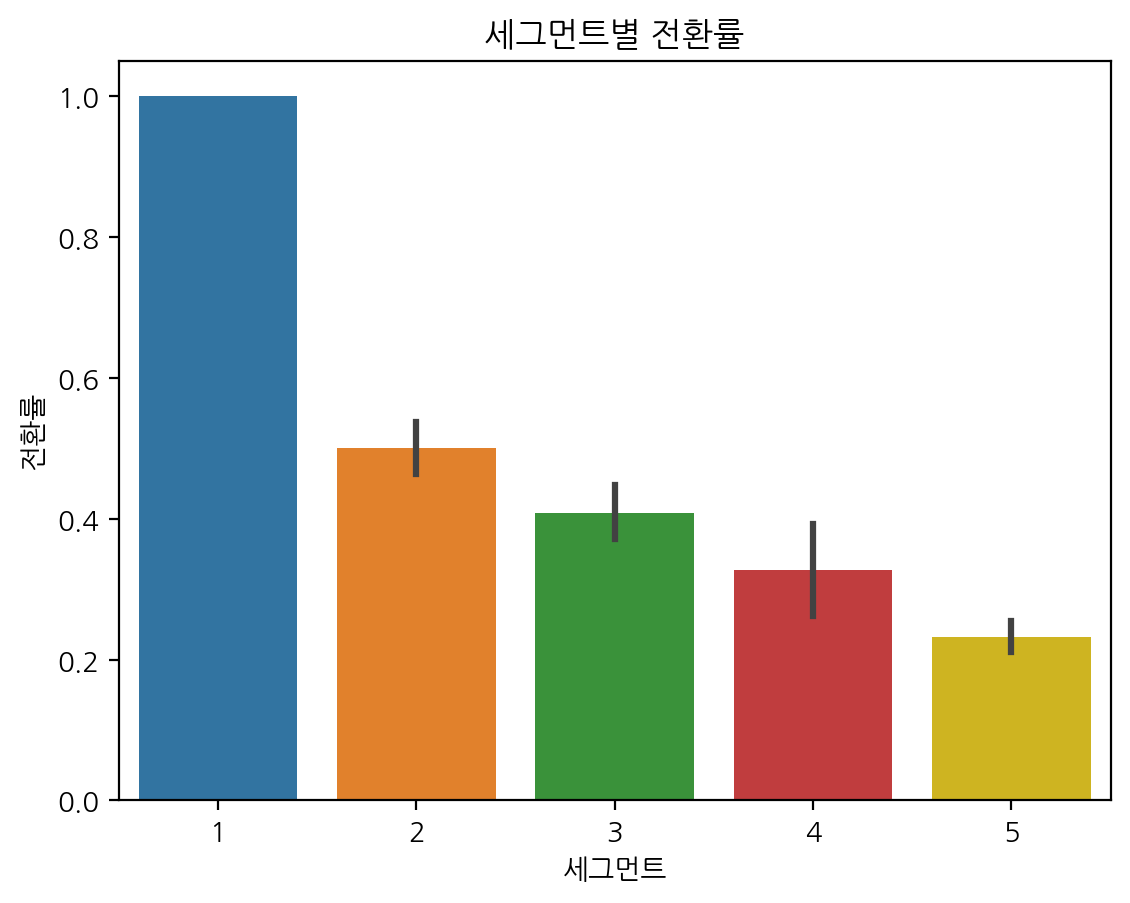

In [91]:
# 3. 시각화
data = user_stats_m_concat[['seg', 'applied']]

fig, ax = plt.subplots()
sns.barplot(data, x='seg', y='applied', ci=95, palette=palette)
plt.title('세그먼트별 전환률')
plt.xlabel('세그먼트')
plt.ylabel('전환률')
plt.show()

### 재지원율 차이 검정(pairwise)

In [ ]:
# 1. 카이 제곱 검정 (전체적으로 차이가 있는지 확인)

# 데이터 준비
data = user_stats_m_concat.groupby(by='seg').agg(
    applied=('reapplied', 'sum'),
    count=('reapplied', 'count')
)
data['not_applied'] = data['count'] - data['applied']
data = data.drop(columns='count')

# 카이제곱 검정
chi2, p, dof, expected = chi2_contingency(data[['applied', 'not_applied']])
expected_table = pd.DataFrame(expected, index=data.index, columns=['applied', 'not_applied'])

print("===== 카이제곱 검정 결과 =====")
print(f"Chi-square 통계량: {chi2:.4f}")
print(f"p-value: {p:.4f}")
print(f"자유도: {dof}")
print("\n기대빈도표:")
print(expected_table)

# 귀무가설 기각됨 (p <0.001)

===== 카이제곱 검정 결과 =====
Chi-square 통계량: 224.1847
p-value: 0.0000
자유도: 4

기대빈도표:
        applied  not_applied
seg                         
1    379.343576  1104.656424
2    192.228012   559.771988
3    144.682253   421.317747
4     54.703184   159.296816
5    377.042975  1097.957025


In [ ]:
# 2. pairwise test (각 세그먼트별로 차이가 있는지 확인)

# 데이터 준비
data = user_stats_m_concat.groupby(by='seg').agg(
            applied = ('reapplied', 'sum'),
            count = ('reapplied', 'count')
        )
data.loc[:, 'not_applied'] = data['count'] - data['applied']
data = data.drop(columns='count')
successes = data['applied'].values
totals = data.sum(axis=1).values

# 가능한 모든 쌍 생성
comparisons = list(itertools.combinations(range(len(data)), 2))
n_tests = len(comparisons)

# Bonferroni 보정된 유의수준
alpha = 0.05
adjusted_alpha = alpha / n_tests

# pairwise test
for i, j in comparisons:
    count = [successes[i], successes[j]]
    nobs = [totals[i], totals[j]]

    stat, pval = proportions_ztest(count, nobs)
    result = '유의미함' if pval < adjusted_alpha else '유의미하지 않음'

    print(f"{data.index[i]} vs {data.index[j]}")
    print(f"Z 통계량: {stat:.4f}")
    print(f"p-value: {pval:.4f}")
    print(f"result: {result}")
    print("============================")

# (세그먼트 2 & 세그먼트 3), (세그먼트 3 & 세그먼트 4), (세그먼트 4 & 세그먼트 5)를 제외한 모든 쌍에서 유의미한 차이가 나타남

1 vs 2
Z 통계량: 3.6782
p-value: 0.0002
result: 유의미함
1 vs 3
Z 통계량: 4.1901
p-value: 0.0000
result: 유의미함
1 vs 4
Z 통계량: 5.1725
p-value: 0.0000
result: 유의미함
1 vs 5
Z 통계량: 14.7263
p-value: 0.0000
result: 유의미함
2 vs 3
Z 통계량: 0.8010
p-value: 0.4231
result: 유의미하지 않음
2 vs 4
Z 통계량: 2.9690
p-value: 0.0030
result: 유의미함
2 vs 5
Z 통계량: 8.9868
p-value: 0.0000
result: 유의미함
3 vs 4
Z 통계량: 2.3616
p-value: 0.0182
result: 유의미하지 않음
3 vs 5
Z 통계량: 7.3410
p-value: 0.0000
result: 유의미함
4 vs 5
Z 통계량: 2.1612
p-value: 0.0307
result: 유의미하지 않음


```
[세그먼트별 특징 요약]
- 세그먼트 1 (빠르고 목표지향적 / 1484명)
    - 조건: 1주일 내 전환
    - 사전 이력서 작성 비율 0.34, 평균 체류 시간 8,231초, 재지원율 0.36, 평균 재지원 횟수 1.22로, 전환에 밀접하게 관련된 주요 행동 지표들에서 가장 우수한 수치를 보인 고가치 유저 집단.
    - 다만 사전 이력서 작성을 제외한 활동성은 평균 수준이며 평균 공고 저장 횟수는 0.87회로 오히려 낮은 편.
    - 가입 후 1주일 내에는 재방문(평균 2.28회) 및 공고 열람(평균 9.66회) 등에서 가장 활발한 활동을 보였으나, 1개월 시점에는 재방문(평균 5.03회)과 공고 열람(평균 14.02회) 모두 다른 세그먼트 대비 순위가 하락함.
- 세그먼트 2 (적극적이고 신중 / 752명)
    - 조건: 1주일 내 미전환, 평균 체류 시간 >= 1500초, 총 페이지뷰 >= 30
    - 지원을 제외한 모든 engagement 및 행동 지표에서 가장 높은 수치를 보임. 지원률(0.50), 재지원률(0.29), 평균 재지원 횟수(0.79) 역시 상위권에 속함.
    - 특히 재방문 횟수(평균 7.72)와 총 페이지뷰(평균 135.07)는 분포가 상위 수치 구간까지 길게 뻗어 있어 다른 세그먼트와 뚜렷하게 구분됨.
    - 3개월 누적 전환률은 71%로, 기존 1개월 전환률 대비 21%p 상승.
- 세그먼트 3 (원하는 정보에 집중 / 566명)
    - 조건: 1주일 내 미전환, 평균 체류 시간 >= 1500초, 총 페이지뷰 < 30
    - 평균 체류 시간은 8,011초로 높으나, 평균 총 페이지 뷰 수(70.88), 평균 키워드 검색 횟수(1.52), 평균 공고 열람 횟수(10.83) 등 대부분의 탐색 행동 지표는 낮음.
- 세그먼트 4 (빠르고 다양한 정보 탐색 / 214명)
    - 조건: 1주일 내 미전환, 평균 체류 시간 < 1500초, 총 페이지뷰 >= 30
    - 평균 체류 시간은 5,147초로 낮지만, 평균 총 페이지뷰 수 105.82, 평균 키워드 검색 횟수 3.35, 평균 공고 열람 횟수19.29, 평균 북마크 수 1.93로 대부분의 행동 지표는 높음.
- 세그먼트 5 (낮은 활동성 / 1475명)
    - 조건: 일주일 내 미전환,  평균 체류 시간 < 1500초, 총 페이지뷰 < 30
    - 전환률 0.23으로 평균 전환률 0.57 대비 절반 수준.
    - 재방문율(0.61), 7D 리텐션율(0.06) 등 모든 engagement 지표가 낮음.
    - 평균 체류 시간(3,892초), 평균 총 페이지뷰 수(45.37), 사전 저장 이력서 작성률(0.14)로 가장 낮은 활동성을 보임.
```

---

```
[세그먼트별 인사이트 및 액션플랜]
- 세그먼트 1 (빠르고 목표지향적 / 1484명)
    - 인사이트: 지원에 필요한 행동을 집중적으로 수행한 후 목표 달성 이후에는 플랫폼 이용이 감소하는 경향을 보임. 목표 지향적이고 효율적인 유저로 해석되며, 단기 성과 중심의 전환 행동 패턴을 보여주는 집단으로 파악됨.
    - 가설: 준비된 이력서와 지원 경험을 바탕으로, 적절한 공고에만 빠르게 지원하고 추가 탐색 없이 이탈하는 목표 중심적 유저일 수 있음
    - 액션 플랜:
        - 과거 지원 이력 기반 공고 추천 이메일 주기적 발송
            - “[퍼포먼스 마케팅] 관련 분야에서 7월 4주차에 가장 인기 많은 공고”
        - ⇒ 개인화된 공고 추천을 통해, 플랫폼 재방문 및 재지원하도록 유도
- 세그먼트 2 (적극적이고 신중 / 752명)
    - 인사이트: 꾸준한 흥미와 필요성을 가지고 적극적으로 플랫폼을 이용하며, 많은 정보를 탐색하고 자신에게 적합한 공고를 신중하게 선택하려는 경향을 보임.
    - 가설: 지원 의지가 전환으로 이어지긴 하나, 지원 준비 시간이 길어지면서 많은 정보량이나 지원 부담 등에 지칠 가능성 있음.
    - 액션 플랜:
        - 지원 없이 탐색 활동만 장기간 지속될 경우 기회를 놓치는 것에 대한 불안감을 자극하는(FOMO) 메시지 전송
            - “오늘 자정 마감인 [00공고]는 지원자 72명 돌파했어요!
            지금 지원하면 늦지 않아요.”
        - ⇒ 지원 준비 시간이 과도하게 길어지는 것을 방지하여, 전환 촉진
- 세그먼트 3 (원하는 정보에 집중 / 566명)
    - 인사이트: 전체 탐색량(페이지뷰, 검색, 공고 열람)은 낮지만 체류 시간은 매우 길어, 제한된 범위의 정보 내에서 깊이 있는 탐색을 하는 것으로 해석됨. 세그먼트 4와 전환률 차이는 통계적으로 유의미하지 않았으나 행동 패턴은 명확히 구분되어 별도의 전략 수립이 필요하다고 판단됨.
    - 가설: 목표하는 분야/회사가 뚜렷한 유저일 가능성 있음.
    - 액션 플랜:
        - 추천 공고에 개인화 컨텐츠 비율 높이기.
        - 특정 업종/직무 맞춤형 컨텐츠 큐레이션된 이메일 전송.
            - “[퍼포먼스 마케팅에 관심있는 다른 신입 구직자]들은 이 공고에 많이 지원했어요!”
        - ⇒ 개인화된 추천으로 탐색 시간을 단축시켜, 빠르게 전환하도록 유도
- 세그먼트 4 (빠르고 다양한 정보 탐색 / 214명)
    - 인사이트: 짧은 시간 안에 다양한 탐색을 시도하지만, 지원으로 이어지지 않는 특성 보임. 세그먼트 3과 전환률 차이는 통계적으로 유의하지 않았지만 탐색 방식과 행동 양상에서 뚜렷한 차이가 보이므로 별도의 접근이 필요하다고 판단됨
    - 가설: 관심 공고는 있으나, 지원 결정을 내리는 기준이 불명확하거나 미비하거나 심리적 부담으로 인해 지원으로 이어지지 않을 가능성이 있음.
    - 액션 플랜:
        - 공고 선택할 기준 제시
            - 간단 직업 성향 테스트 → 관련 공고 추천 (자기 탐색 도움)
            - “나와 비슷한 사람들이 많이 지원한 곳”(사회적 증거 활용)
        - 직접 말 거는 친근한 어투로, 적은 수의 공고를 추천하는 이메일 발송
            - “공고 너무 많으면 고민되죠? 지금 시작하기 좋은 딱 3개만 추천드릴게요.”
        - ⇒ 명확한 기준을 제시하고 심리적 부담을 완화하여, 전환 장벽을 낮추도록 유도
- 세그먼트 5 (낮은 활동성 / 1475명)
    - 인사이트: 전체 세그먼트 중 두 번째로 큰 규모를 차지하지만 활동량이 매우 적으며 플랫폼에 대한 관심도나 참여도가 낮은 것으로 보임.
    - 가설: 명확한 구직 동기가 없는 초기 유저거나 서비스 이해도가 낮을 가능성이 있음.
    - 액션 플랜:
        - 온보딩 게임화: 온보딩 미션을 미션 보드 형태로 제공
            - ex) “취뽀여정 Lv2 퀘스트: 공고 3개 열람해보기” → 성공 시 칭찬 메시지와 함께 레벨업 그래픽, 이후 미션 안내
        - ⇒ 흥미 요소를 활용한 진입 경험과 작은 성공의 성취감을 통해 플랫폼 적응 장벽을 낮춤
```